In [1]:
%pip install einops
#%pip install einops -i https://pypi.tuna.tsinghua.edu.cn/simple
%pip install timm
%pip install torchsummary -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
# coding=utf-8
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import itertools
import random
from torch.autograd import Variable

import time
import datetime
from torchvision.utils import save_image,make_grid
import sys
import functools


import copy
import logging
import math
from torch.nn.utils import spectral_norm
from os.path import join as pjoin
#import tifffile as tiff

In [3]:
writer = SummaryWriter(log_dir = 'tf-logs/denoising',flush_secs = 60)
seed = 11

In [4]:
print(torch.cuda.is_available())

True


In [5]:
#---------------------------------------------------#
#   设置种子
#---------------------------------------------------#
def seed_everything(seed=11):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [6]:
#---------------------------------------------------#
#   设置Dataloader的种子
#---------------------------------------------------#
def _init_fn(worker_id):
    np.random.seed(int(seed)+worker_id)


In [7]:
seed_everything(seed=11)

In [8]:
L1_function = torch.nn.L1Loss()
BATCH_SIZE =3
EPOCH = 200
IMAGE_SIZE = 448

In [9]:
A_Path=sorted(glob.glob('./deblurring/pc3m-63obj/trainA/*.tif'))
print('trainA中共有{}张图片'.format(len(A_Path)))
B_Path=sorted(glob.glob('./deblurring/pc3m-63obj/trainB/*.tif'))
print('trainB中共有{}张图片'.format(len(B_Path)))
test_A_Path=sorted(glob.glob('./deblurring/pc3m-63obj/testA/*.tif'))
print('testA中共有{}张图片'.format(len(test_A_Path)))
test_B_Path=sorted(glob.glob('./deblurring/pc3m-63obj/testB/*.tif'))
print('testB中共有{}张图片'.format(len(test_B_Path)))

trainA中共有1477张图片
trainB中共有1873张图片
testA中共有126张图片
testB中共有126张图片


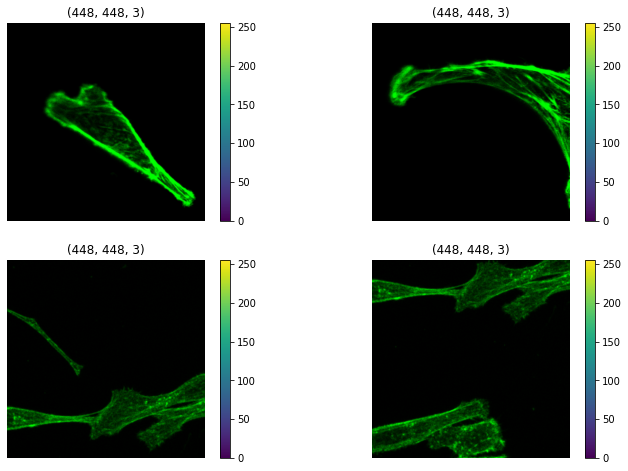

In [10]:
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(A_Path[:4]):
    img = Image.open(img_path)
    np_img = np.array(img)
    plt.subplot(2, 2, i+1)
    plt.imshow(np_img)
    plt.title(str(np_img.shape))
    plt.axis('off')
    plt.colorbar()
plt.show()

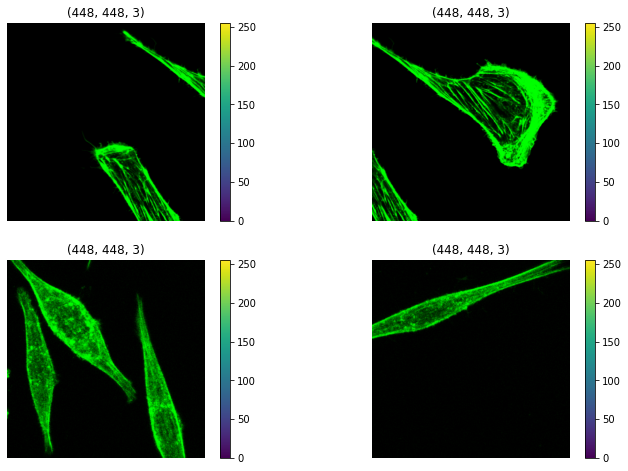

In [11]:
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(B_Path[:4]):
    img = Image.open(img_path)
    np_img = np.array(img)
    plt.subplot(2, 2, i+1)
    plt.imshow(np_img)
    plt.title(str(np_img.shape))
    plt.axis('off')
    plt.colorbar()
plt.show()

In [12]:
transforms_ = transforms.Compose([ transforms.Resize([448,448]), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]) 

In [13]:
'''
class A2BDataset(data.Dataset):
    def __init__(self,A_path,B_path,unaligned = True):
        self.A_path = A_path
        self.B_path = B_path
        self.transform = transforms_
        self.unaligned = unaligned
    def __getitem__(self, index):
        A_path = self.A_path[index % len(self.A_path)]
        pil_A = Image.open(A_path)  # 默认会解析为channel为1的图片
        pil_A = transforms.Resize([512,512])(pil_A)
        pil_A = np.asarray(pil_A).astype(np.float32)
        pil_A1 = torch.from_numpy(pil_A)#变为张量
        pil_A2 = pil_A1.unsqueeze(2).numpy()/(65535/255)                                #增加一个维度    255 for 8 bit or 65535 for 16 bit
        pil_A2 = pil_A2/127.5 -1#归一化到[-1,1]
        A = torch.from_numpy(pil_A2).permute(2,0,1)#把channel维度放到前面

        if self.unaligned:                                                              ## 如果采用非配对数据，在B中随机取一张
            B_path = self.B_path[random.randint(0, len(self.B_path) - 1)]
        else:
            B_path = self.B_path[index]

        pil_B = Image.open(B_path)
        pil_B = transforms.Resize([512,512])(pil_B)
        pil_B = np.asarray(pil_B).astype(np.float32)
        pil_B1 = torch.from_numpy(pil_B)
        pil_B2 = pil_B1.numpy()/(255/255)
        pil_B2 = pil_B2/127.5 -1
        B = torch.from_numpy(pil_B2).permute(2,0,1)
        return A,B

    def __len__(self):
        return max(len(self.A_path), len(self.B_path))
'''

'\nclass A2BDataset(data.Dataset):\n    def __init__(self,A_path,B_path,unaligned = True):\n        self.A_path = A_path\n        self.B_path = B_path\n        self.transform = transforms_\n        self.unaligned = unaligned\n    def __getitem__(self, index):\n        A_path = self.A_path[index % len(self.A_path)]\n        pil_A = Image.open(A_path)  # 默认会解析为channel为1的图片\n        pil_A = transforms.Resize([512,512])(pil_A)\n        pil_A = np.asarray(pil_A).astype(np.float32)\n        pil_A1 = torch.from_numpy(pil_A)#变为张量\n        pil_A2 = pil_A1.unsqueeze(2).numpy()/(65535/255)                                #增加一个维度    255 for 8 bit or 65535 for 16 bit\n        pil_A2 = pil_A2/127.5 -1#归一化到[-1,1]\n        A = torch.from_numpy(pil_A2).permute(2,0,1)#把channel维度放到前面\n\n        if self.unaligned:                                                              ## 如果采用非配对数据，在B中随机取一张\n            B_path = self.B_path[random.randint(0, len(self.B_path) - 1)]\n        else:\n            B_path = 

In [14]:
class A2BDataset(data.Dataset):
    def __init__(self,A_path,B_path,unaligned = True):
        self.A_path = A_path
        self.B_path = B_path
        self.transform = transforms_
        self.unaligned = unaligned
    def __getitem__(self, index):
        A_path = self.A_path[index % len(self.A_path)]
        pil_A = Image.open(A_path) 
        pil_A = pil_A.convert('RGB')  
        pil_A = transforms_(pil_A)

        if self.unaligned:                                                           
            B_path = self.B_path[random.randint(0, len(self.B_path) - 1)]
        else:
            B_path = self.B_path[index]

        pil_B = Image.open(B_path)
        pil_B = pil_B.convert('RGB')      
        pil_B = transforms_(pil_B)
        return pil_A,pil_B

    def __len__(self):
        return max(len(self.A_path), len(self.B_path))

In [15]:
A2B_Dataset = A2BDataset(A_path=A_Path,B_path=B_Path)
len(A2B_Dataset)
test_A2B_Dataset = A2BDataset(A_path = test_A_Path,B_path = test_B_Path,unaligned = False)
len(test_A2B_Dataset)

126

In [16]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.utils.spectral_norm):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(input_nc,64,4,2,1),nn.LeakyReLU(0.2,True))
        self.layer2 = nn.Sequential(spectral_norm(nn.Conv2d(64,128,4,2,1)),nn.LeakyReLU(0.2,True))
        self.layer3 = nn.Sequential(spectral_norm(nn.Conv2d(128,256,4,2,1)),nn.LeakyReLU(0.2,True))
        self.layer4 =  nn.Sequential(spectral_norm(nn.Conv2d(256,512,4,1,1)),nn.LeakyReLU(0.2,True))
        self.layer5 =  nn.Sequential(spectral_norm(nn.Conv2d(512,1,4,1,1)),nn.LeakyReLU(0.2,True))

    def forward(self,x):
        """Standard forward."""
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [17]:
net = NLayerDiscriminator(input_nc =3, ndf = 64, n_layers=3, norm_layer=nn.utils.spectral_norm)
#print(net)
net = net.to('cuda')
summary(net,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
         LeakyReLU-2         [-1, 64, 112, 112]               0
            Conv2d-3          [-1, 128, 56, 56]         131,200
         LeakyReLU-4          [-1, 128, 56, 56]               0
            Conv2d-5          [-1, 256, 28, 28]         524,544
         LeakyReLU-6          [-1, 256, 28, 28]               0
            Conv2d-7          [-1, 512, 27, 27]       2,097,664
         LeakyReLU-8          [-1, 512, 27, 27]               0
            Conv2d-9            [-1, 1, 26, 26]           8,193
        LeakyReLU-10            [-1, 1, 26, 26]               0
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.14
Params size (MB): 10.55
Estim

In [18]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [19]:
#W-MSA和SW-MSA首先需要将特征图拆分成多个windows
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

In [20]:

def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [21]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        #随机生成位置偏置表
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        # [2,Mh*Mw,1] - [2,1,Mh*Mw]
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0，先将每一行加上windows_h -1
        relative_coords[:, :, 1] += self.window_size[1] - 1  #每一列加上window_w -1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1 #然后将每一行乘上 2*window_w -1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww 行列位置相加
        self.register_buffer("relative_position_index", relative_position_index)  # 保存数据，不再更新

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)   # 线性层，特征维度变为原来的 3倍
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)   # 线性层，特征维度不变
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)   # 截断正态分布，限制标准差为 0.02
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        # [batch_size*num_windows, Mh*Mw, total_embed_dim]
        B_, N, C = x.shape
        # 将特征图的通道维度按照注意力头的个数重新划分，并再做交换维度操作
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)  #3指的是q,k,v
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple) 方便后续写代码，重新赋值

        q = q * self.scale
        # @ 代表常规意义上的矩阵相乘
        attn = (q @ k.transpose(-2, -1))     # q 和 k 相乘后并交换最后两个维度

        # 相对位置偏移，结构为 [Wh*Ww, Wh*Ww, num_heads]
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        # 相对位置偏移交换维度，结构为 [num_heads, Wh*Ww, Wh*Ww]
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)    # 带相对位置偏移的注意力图

        if mask is not None:  #判断是否有mask
            nW = mask.shape[0]     # mask 的宽
            # attn.view: [batch_size, num_windows, num_heads, Mh*Mw, Mh*Mw]
            # mask.unsqueeze: [1, nW, 1, Mh*Mw, Mh*Mw]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)   # 注意力图与 mask 相加
            attn = attn.view(-1, self.num_heads, N, N)     # 恢复注意力图原来的结构
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)     # 随机设置注意力图中的部分值为 0

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)   ## 注意力图与 v 相乘得到新的注意力图
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

In [22]:
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            # 以下两 slices 中的数据是索引，具体缘由尚未搞懂
            h_slices = (slice(0, -self.window_size),                     # 索引 0 到索引倒数第 window_size
                        slice(-self.window_size, -self.shift_size),      # 索引倒数第 window_size 到索引倒数第 shift_size
                        slice(-self.shift_size, None))                   # 索引倒数第 shift_size 后所有索引
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt                           # 将 img_mask 中 h, w 对应索引范围的值置为 cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)   # 重构结构为二维张量，列数为 [nW,window_size*window_size]
            #涉及广播机制 [nW,1,Mh*Mw] - [nw,Mh*Mw,1]
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)           # 增加第 2 维度减去增加第 3 维度的注意力 mask [nW,window_size*window_size,window_size*window_size]
            # 用浮点数 -100. 填充注意力 mask 中值不为 0 的元素，再用浮点数 0. 填充注意力 mask 中值为 0 的元素
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))  #高度和宽度方向
        else:    #普通的msa
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

In [23]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

In [24]:
class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2*dim, bias=False) if dim_scale==2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C//4)
        x = x.view(B,-1,C//4)
        x= self.norm(x)

        return x

In [25]:
class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 16*dim, bias=False)
        self.output_dim = dim 
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//(self.dim_scale**2))
        x = x.view(B,-1,self.output_dim)
        x= self.norm(x)

        return x

In [26]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

In [27]:
class BasicLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x

In [28]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=IMAGE_SIZE, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

In [29]:
class SwinTransformerSys(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=IMAGE_SIZE, patch_size=4, in_chans=3, num_classes=3,
                 embed_dim=96, depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()

        print("SwinTransformerSys expand initial----depths:{};depths_decoder:{};drop_path_rate:{};num_classes:{}".format(depths,
        depths_decoder,drop_path_rate,num_classes))

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build encoder and bottleneck layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)
        
        # build decoder layers
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2*int(embed_dim*2**(self.num_layers-1-i_layer)),
            int(embed_dim*2**(self.num_layers-1-i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer ==0 :
                layer_up = PatchExpand(input_resolution=(patches_resolution[0] // (2 ** (self.num_layers-1-i_layer)),
                patches_resolution[1] // (2 ** (self.num_layers-1-i_layer))), dim=int(embed_dim * 2 ** (self.num_layers-1-i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers-1-i_layer)),
                                input_resolution=(patches_resolution[0] // (2 ** (self.num_layers-1-i_layer)),
                                                    patches_resolution[1] // (2 ** (self.num_layers-1-i_layer))),
                                depth=depths[(self.num_layers-1-i_layer)],
                                num_heads=num_heads[(self.num_layers-1-i_layer)],
                                window_size=window_size,
                                mlp_ratio=self.mlp_ratio,
                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                drop=drop_rate, attn_drop=attn_drop_rate,
                                drop_path=dpr[sum(depths[:(self.num_layers-1-i_layer)]):sum(depths[:(self.num_layers-1-i_layer) + 1])],
                                norm_layer=norm_layer,
                                upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm = norm_layer(self.num_features)
        self.norm_up= norm_layer(self.embed_dim)

        if self.final_upsample == "expand_first":
            print("---final upsample expand_first---")
            self.up = FinalPatchExpand_X4(input_resolution=(img_size//patch_size,img_size//patch_size),dim_scale=4,dim=embed_dim)
            self.output = nn.Conv2d(in_channels=embed_dim,out_channels=self.num_classes,kernel_size=1,bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    #Encoder and Bottleneck
    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []

        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)

        x = self.norm(x)  # B L C
  
        return x, x_downsample

    #Dencoder and Skip connection
    def forward_up_features(self, x, x_downsample):
        #skip connection
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x,x_downsample[3-inx]],-1)
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)

        x = self.norm_up(x)  # B L C
  
        return x

    def up_x4(self, x):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H*W, "input features has wrong size"

        if self.final_upsample=="expand_first":
            x = self.up(x)
            x = x.view(B,4*H,4*W,-1)
            x = x.permute(0,3,1,2) #B,C,H,W
            x = self.output(x)
            
        return x

    def forward(self, x):
        x, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x,x_downsample)
        x = self.up_x4(x)

        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [30]:
class SwinUnet(nn.Module):
    def __init__(self, img_size=IMAGE_SIZE, in_chans = 3,num_classes=3, zero_head=False, vis=False):
        super(SwinUnet, self).__init__()
        self.num_classes = num_classes
        self.in_chans = in_chans
        self.zero_head = zero_head

        self.swin_unet = SwinTransformerSys(img_size=IMAGE_SIZE,    #224
                                patch_size=4,                       #4
                                in_chans=self.in_chans,             #3
                                num_classes=self.num_classes,       #21843
                                embed_dim=96,                       #96
                                depths=[2,2,6,2],                   #[2,2,6,2]
                                num_heads=[3,6,12,24],              #[3,6,12,24]
                                window_size=7,                      #7
                                mlp_ratio=4,                        #4
                                qkv_bias=True,                      #True
                                qk_scale=None,                      #None
                                drop_rate=0.0,                      #0.0
                                drop_path_rate=0.1,                 #0.1
                                ape=False,                          #False
                                patch_norm=True,                    #True
                                use_checkpoint=False)               #False
    '''
    比如，如果输入数据的是单通道灰度图（医疗图像切片一般都是单通道除非是多模态），
    可以像这样在通道维度复制三次，
    就变成和RGB图像一样的三通道了，
    输入模型就可以避免报错。
    另一种方法是直接在模型初始化的时候把通道数设为1，就不需要这两行操作了。
    '''
    def forward(self, x):
        #if x.size()[1] == 1:
            #x = x.repeat(1,3,1,1)
        logits = torch.tanh(self.swin_unet(x))
        return logits

    def load_from(self):
        pretrained_path = 'pretrained-ckpt/swin_tiny_patch4_window7_224.pth'
        if pretrained_path is not None:
            print("pretrained_path:{}".format(pretrained_path))
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            pretrained_dict = torch.load(pretrained_path, map_location=device)
            if "model"  not in pretrained_dict:
                print("---start load pretrained modle by splitting---")
                pretrained_dict = {k[17:]:v for k,v in pretrained_dict.items()}
                for k in list(pretrained_dict.keys()):
                    if "output" in k:
                        print("delete key:{}".format(k))
                        del pretrained_dict[k]
                msg = self.swin_unet.load_state_dict(pretrained_dict,strict=False)
                # print(msg)
                return
            pretrained_dict = pretrained_dict['model']
            print("---start load pretrained modle of swin encoder---")
            # print("pretrained_dict['model']==",pretrained_dict.keys())
            # 此时pretrained_dict包含swin_transformer的全部权重keys-------------------------------
            # 对于tiny其中的[2,2,6,2]encoder，有layers.0.blocks.0.到layers.2.blocks.5.到layers.3.blocks.2.

            model_dict = self.swin_unet.state_dict()
            full_dict = copy.deepcopy(pretrained_dict)
            # 将映射出的decoder,和原本的encoder的所有权重都存在full_dict里
            # print("full_dict(all)==", full_dict.keys())
            for k, v in pretrained_dict.items():
                if "layers." in k:
                    current_layer_num = 3-int(k[7:8])
                    # print("current_layer_num==",current_layer_num)
                    # current_layer_num现有layer=原有layer总数4-现有layer
                    current_k = "layers_up." + str(current_layer_num) + k[8:]
                    # 将（tiny）encoder[2，2，6，2]对称地映射出一个decoder权重
                    # print("current_k==",current_k)
                    full_dict.update({current_k:v})
            for k in list(full_dict.keys()):
            # 遍历full_dict，如果和model_dict（swin_unet）的key相同，就判断尺寸是否匹配，如果不匹配就删除
                if k in model_dict:
                    if full_dict[k].shape != model_dict[k].shape:
                        print("delete:{};shape pretrain:{};shape model:{}".format(k,v.shape,model_dict[k].shape))
                        del full_dict[k]

            msg = self.swin_unet.load_state_dict(full_dict, strict=False)
            # print(msg)
            # 正式执行加载权重。strict=False 表示忽略不匹配的网络层参数
            # 除了.layers_up.1/2/3.upsample没加载预训练权重，都加载了
        else:
            print("none pretrain")

In [31]:
## 先前生成的样本的缓冲区
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):                       ## 放入一张图像，再从buffer里取一张出来
        to_return = []                                  ## 确保数据的随机性，判断真假图片的鉴别器识别率
        for element in data.data:
            element = torch.unsqueeze(element, 0)       ##返回一个新的张量，对输入的既定位置插入维度 1
            if len(self.data) < self.max_size:          ## 最多放入50张
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:          ## 满了就1/2的概率从buffer里取，或者就用当前的输入图片
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [32]:
## 设置学习率为初始学习率乘以给定lr_lambda函数的值
class LambaLR:
    def __init__(self,epoch_count = 1,n_epochs =100,n_epoch_decay = 100):
        self.epoch_count = epoch_count
        self.n_epochs = n_epochs
        self.n_epoch_decay = n_epoch_decay

    def step(self,epoch):
        return 1.0 - max(0,epoch+self.epoch_count-self.n_epochs) / float(self.n_epoch_decay + 1)

In [33]:
## 定义参数初始化函数
def weights_init_normal(m):                                    
    classname = m.__class__.__name__                        ## m作为一个形参，原则上可以传递很多的内容, 为了实现多实参传递，每一个moudle要给出自己的name. 所以这句话就是返回m的名字. 
    if classname.find("Conv") != -1:                        ## find():实现查找classname中是否含有Conv字符，没有返回-1；有返回0.
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)     ## m.weight.data表示需要初始化的权重。nn.init.normal_():表示随机初始化采用正态分布，均值为0，标准差为0.02.
        if hasattr(m, "bias") and m.bias is not None:       ## hasattr():用于判断m是否包含对应的属性bias, 以及bias属性是否不为空.
            torch.nn.init.constant_(m.bias.data, 0.0)       ## nn.init.constant_():表示将偏差定义为常量0.
    elif classname.find("BatchNorm2d") != -1:               ## find():实现查找classname中是否含有BatchNorm2d字符，没有返回-1；有返回0.
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)     ## m.weight.data表示需要初始化的权重. nn.init.normal_():表示随机初始化采用正态分布，均值为0，标准差为0.02.
        torch.nn.init.constant_(m.bias, 0.0)           ## nn.init.constant_():表示将偏差定义为常量0.

In [34]:
os.makedirs('./images',exist_ok=True)
os.makedirs('./save',exist_ok=True)
os.makedirs('./message',exist_ok = True)

In [35]:
def print_network(model):
    num_params = 0
    for param in model.parameters():
        num_params += param.numel()
    #print(net)
    print('Total number of parameters: %d' % num_params)

In [36]:
D_A = NLayerDiscriminator(input_nc =3, ndf = 64, n_layers=3, norm_layer=nn.utils.spectral_norm)
D_B = NLayerDiscriminator(input_nc =3, ndf = 64, n_layers=3, norm_layer=nn.utils.spectral_norm)
G_AB = SwinUnet(in_chans=3,num_classes=3)
G_BA = SwinUnet(in_chans=3,num_classes=3)

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:3


/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---
SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:3
---final upsample expand_first---


In [37]:
def add_sn(model):
    """谱归一化,传入模型实例即可"""
    for name, layer in model.named_children():
        model.add_module(name, add_sn(layer))
        if isinstance(model, (nn.Linear)):
            return nn.utils.spectral_norm(model)
        else:
            return model
    return model

In [38]:
#add_sn(G_AB)
#add_sn(G_BA)

SwinUnet(
  (swin_unet): SwinTransformerSys(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=96, input_resolution=(112, 112), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=96, input_resolution=(112, 112), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=96, window_size=(7, 7), num_heads=3
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
    

In [39]:
x = torch.randn((1,3,448,448))
A  = G_AB(x)
print(A.shape)
B = D_A(x)
print(B.shape)

torch.Size([1, 3, 448, 448])
torch.Size([1, 1, 54, 54])


In [40]:
print_network(G_AB)
print_network(G_BA)
print_network(D_A)
print_network(D_B)

Total number of parameters: 41380260
Total number of parameters: 41380260
Total number of parameters: 2764737
Total number of parameters: 2764737


In [41]:
writer.add_graph(G_AB,x)
writer.add_graph(D_A,x)

/tmp/ipykernel_1437/1740156543.py:34: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H == self.img_size[0] and W == self.img_size[1], \
/tmp/ipykernel_1437/3147517230.py:77: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert L == H * W, "input feature has wrong size"
/tmp/ipykernel_1437/3004052929.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the curr

In [42]:
## 损失函数
## MES 二分类的交叉熵
## L1loss 相比于L2 Loss保边缘
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [43]:
D_A = D_A.cuda()
D_B = D_B.cuda()
G_AB = G_AB.cuda()
G_BA = G_BA.cuda()

In [44]:
if IMAGE_SIZE ==224:
    G_AB.load_from()
    G_BA.load_from()
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

NLayerDiscriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)

In [45]:
#定义优化函数
optimizer_G = torch.optim.RMSprop(
    itertools.chain(G_AB.parameters(),G_BA.parameters()),lr = 2e-4)

optimizer_D = torch.optim.RMSprop(
    itertools.chain(D_A.parameters(),D_B.parameters()),lr = 2e-4)

#学习率更新进程
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G,lr_lambda=LambaLR().step)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D,lr_lambda=LambaLR().step)
#样本缓冲区
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [47]:
A2B_dataloader = data.DataLoader(        ## 改成自己存放文件的目录
    A2B_Dataset,                                        ## unaligned:设置非对qi数据
    batch_size=BATCH_SIZE,                      ## batch_size = 1
    shuffle=False,                                      ##因为已经有batch_size了，就不需要shuffle来进行随机了，将shuffle设置为FALSE即可
    num_workers=2,
    worker_init_fn = _init_fn)

In [49]:
test_dataloader = data.DataLoader(        ## 改成自己存放文件的目录
    test_A2B_Dataset,                    ## " unaligned:设置非对齐数据
    batch_size=1,                        ## batch_size = 1
    shuffle=False,                      
    num_workers=0,
    worker_init_fn = _init_fn)

训练数据集：


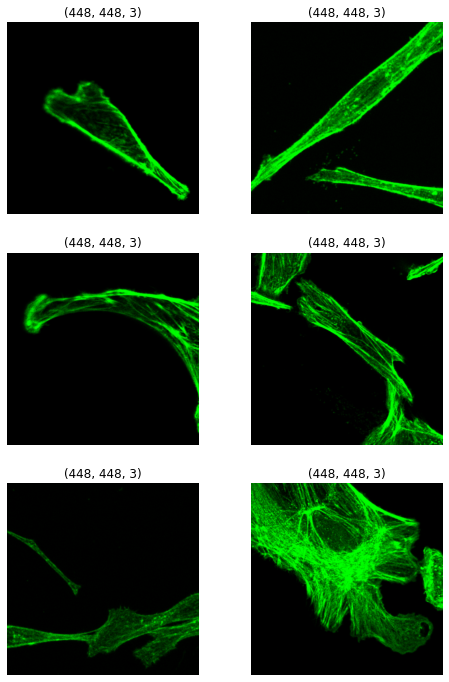

In [50]:
import matplotlib.image as mpimg #mpimg用于读取图片
A_batch,B_batch=next(iter(A2B_dataloader))
plt.figure(figsize = (8,12))
print('训练数据集：')
for i,(real_A,real_B) in enumerate(zip(A_batch[:3],B_batch[:3])):
    A = (real_A.permute(1,2,0).numpy()+1)/2
    B = (real_B.permute(1,2,0).numpy()+1)/2
    
    plt.subplot(3,2,2*i+1)
    plt.title(str(A.shape))
    plt.axis('off')
    plt.imshow(A)
    plt.subplot(3,2,2*i+2)
    plt.title(str(B.shape))
    plt.axis('off')
    plt.imshow(B)
plt.show()

测试数据集：


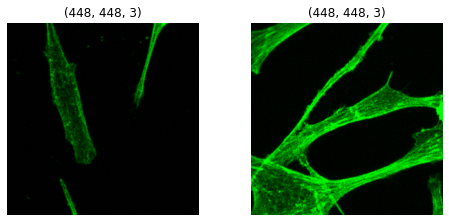

In [51]:
import matplotlib.image as mpimg #mpimg用于读取图片
A_batch,B_batch=next(iter(test_dataloader))
plt.figure(figsize = (8,12))
print('测试数据集：')
for i,(real_A,real_B) in enumerate(zip(A_batch[:3],B_batch[:3])):
    A = (real_A.permute(1,2,0).numpy()+1)/2
    B = (real_B.permute(1,2,0).numpy()+1)/2
    
    plt.subplot(3,2,2*i+1)
    plt.title(str(A.shape))
    plt.axis('off')
    plt.imshow(A)
    plt.subplot(3,2,2*i+2)
    plt.title(str(B.shape))
    plt.axis('off')
    plt.imshow(B)
plt.show()

In [52]:
#每间隔100次打印图片
def sample_images(batches_done):
    #保存测试集中生成的样本
    (A,B) = next(iter(test_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(A).cuda() #取一张真A
    fake_B = G_AB(real_A)

    real_B = Variable(B).cuda()
    fake_A = G_BA(real_B)

    # Arange images along x-axis
    ## make_grid():用于把几个图像按照网格排列的方式绘制出来
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    ## 把以上图像都拼接起来，保存为一张大图片
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "./images/%s.tif" % (batches_done), normalize=False)

In [53]:
def generate_image(model, test_input, true_target, epoch_num):

    predictions = []
    test_inputs = []
    true_targets = []
    for i,input in enumerate(test_input):
        predictions.append(model(test_input[i].cuda()).permute(0, 2, 3, 1).detach().cpu().numpy())  # 0是batch值
        test_inputs.append(test_input[i].permute(0, 2, 3, 1).cpu().numpy())
        true_targets.append(true_target[i].permute(0, 2, 3, 1).cpu().numpy())
    plt.figure(figsize=(30, 10))
    plt.axis('off')

    for i, (img, mask) in enumerate(zip(test_inputs, true_targets)):
        plt.subplot(3, 9, i+1)
        plt.title('Input:')
        #plt.imshow(denormalize(img.squeeze()).astype('uint8'))
        plt.imshow(test_input[i] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(3,9, i + 10)
        plt.title('Output:')
        #plt.imshow(denormalize(predictions[i].squeeze()).astype('uint8'))
        plt.imshow(prediction[i] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(3, 9, i + 19)
        plt.title('ground_truth:')
        #plt.imshow(denormalize(mask.squeeze()).astype('uint8'))
        plt.imshow(true_target[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    plt.close()

In [54]:
def generate_images(modelAB ,modelBA , test_input ,true_target ,epoch_num):

    fake_B = modelAB(test_input.cuda()).permute(0, 2, 3, 1).detach().cpu().numpy()  # 0是batch值
    fake_A = modelBA(true_target.cuda()).permute(0, 2, 3, 1).detach().cpu().numpy()  # 0是batch值
    test_input = test_input.permute(0, 2, 3, 1).cpu().numpy()
    true_target = true_target.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=(8, 12))
    plt.axis('off')

    for i, (real_A, real_B) in enumerate(zip(test_input[:1], true_target[:1])):

        plt.subplot(1, 4, i + 1)
        plt.title('Real_A:')
        #plt.imshow(denormalize(test_input[i]).astype('uint8'))
        plt.imshow(test_input[i] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(1, 4, i + 2)
        plt.title('Fake_B:')
        #plt.imshow(denormalize(prediction[i]).astype('uint8'))
        plt.imshow(fake_B[i] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(1, 4, i + 3)
        plt.title('Real_B:')
        #plt.imshow(denormalize(true_target[i]).astype('uint8'))
        plt.imshow(true_target[i] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(1, 4, i + 4)
        plt.title('Fake_A:')
        #plt.imshow(denormalize(true_target[i]).astype('uint8'))
        plt.imshow(fake_A[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    plt.close()

In [55]:
def type_trans(window,img):
    if img.is_cuda:
        window = window.cuda(img.get_device())
    return window.type_as(img)

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):

    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)
    # print(mu1.shape,mu2.shape)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12   = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    mcs_map  = (2.0 * sigma12 + C2)/(sigma1_sq + sigma2_sq + C2)
    # print(ssim_map.shape)
    if size_average:
        return ssim_map.mean(), mcs_map.mean()
    # else:
    #     return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average

    def forward(self, img1, img2):
        _, channel, _, _ = img1.size()
        window = create_window(self.window_size,channel)
        window = type_trans(window,img1)
        ssim_map, mcs_map =_ssim(img1, img2, window, self.window_size, channel, self.size_average)
        return ssim_map


class MS_SSIM(torch.nn.Module):
    def __init__(self, window_size = 11,size_average = True):
        super(MS_SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        # self.channel = 3

    def forward(self, img1, img2, levels=5):

        weight = Variable(torch.Tensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]))

        msssim = Variable(torch.Tensor(levels,))
        mcs    = Variable(torch.Tensor(levels,))

        if torch.cuda.is_available():
            weight =weight.cuda()
            msssim=msssim.cuda()
            mcs=mcs.cuda()

        _, channel, _, _ = img1.size()
        window = create_window(self.window_size,channel)
        window = type_trans(window,img1)

        for i in range(levels): #5 levels
            ssim_map, mcs_map = _ssim(img1, img2,window,self.window_size, channel, self.size_average)
            msssim[i] = ssim_map
            mcs[i] = mcs_map
            # print(img1.shape)
            filtered_im1 = F.avg_pool2d(img1, kernel_size=2, stride=2)
            filtered_im2 = F.avg_pool2d(img2, kernel_size=2, stride=2)
            img1 = filtered_im1 #refresh img
            img2 = filtered_im2

        return torch.prod((msssim[levels-1]**weight[levels-1] * mcs[0:levels-1]**weight[0:levels-1]))
        # return torch.prod((msssim[levels-1] * mcs[0:levels-1]))
        #torch.prod: Returns the product of all elements in the input tensor

In [56]:
D_loss=[]
G_GAN_loss =[]
G_Content_loss = []
G_Cycle_loss = []
G_loss=[]
#D_epoch_loss = 0
#G_epoch_loss = 0

In [57]:
ssim_loss = SSIM()
from math import exp

In [58]:
total_iters = 0
def train():
    prev_time = time.time()
    for epoch in range(1,EPOCH+1):
        global total_iters
        D_epoch_loss = 0
        G_epoch_loss = 0
        G_epoch_GAN_loss = 0
        G_epoch_Cycle_loss= 0
        G_epoch_Content_loss = 0
        epoch_iter = 0
        for i,(A,B) in enumerate(A2B_dataloader):
            total_iters+=BATCH_SIZE
            epoch_iter+=BATCH_SIZE
            counter = total_iters
            #读取数据集中真图片
            #将tensor变成variable放入计算图中，tensor变成variable之后才能进行反向传播
            real_A = Variable(A).cuda()  #真图像A
            real_B = Variable(B).cuda()  #真图像B

            #全真、全假的标签
            #valid = Variable(torch.ones((real_A.size(0),*D_A.output_shape)),requires_grad = False).cuda()
            #fake = Variable(torch.zeros((real_A.size(0),*D_A.output_shape)),requires_grad = False).cuda() 
            #fake_label_B = Variable(torch.zeros((real_B.size(0),*D_B.output_shape)),requires_grad = False).cuda()
            #print(valid.shape)
            #print(fake.shape)
            #print(fake_label_B.shape)

            ## -----------------
            ##  Train Generator
            ## 原理：目的是希望生成的假的图片被判别器判断为真的图片，
            ## 在此过程中，将判别器固定，将假的图片传入判别器的结果与真实的label对应，
            ## 反向传播更新的参数是生成网络里面的参数，
            ## 这样可以通过更新生成网络里面的参数，来训练网络，使得生成的图片让判别器以为是真的, 这样就达到了对抗的目的
            ## -----------------
            #WGAN 
            for p in D_A.parameters():
                p.data.clamp_(-0.01, 0.01)
            for p in D_B.parameters():
                p.data.clamp_(-0.01, 0.01)
            G_AB.train()
            G_BA.train()

            optimizer_G.zero_grad()          ### 在反向传播之前，先将梯度归0
            #Identity loss
            #loss_id_A = L1_function(G_BA(real_A),real_A)
            #loss_id_B = L1_function(G_AB(real_B),real_B)

            #ssim_out_A = ssim_loss(real_B, fake_B)
            #ssim_out_B = ssim_loss(real_A,fake_A)
            #loss_identity = 1- (ssim_out_A.data+ssim_out_B.data)
            loss_identity = 0


            #GAN loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B),torch.ones_like(D_B(fake_B),device = 'cuda'))
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A),torch.ones_like(D_A(fake_A),device = 'cuda'))

            loss_GAN = loss_GAN_AB+loss_GAN_BA

            #cycle consistency loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recov_A,real_A)
            recov_B =G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B,real_B)

            loss_cycle = loss_cycle_A+loss_cycle_B

            #创新点:
            
            real_A_mean = torch.mean(real_A,dim = 2,keepdim=True)
            real_B_mean = torch.mean(real_B,dim = 2,keepdim=True)
            fake_A_mean = torch.mean(fake_A,dim = 2,keepdim=True)
            fake_B_mean = torch.mean(fake_B,dim =2,keepdim=True)

            real_A_normal = (real_A_mean - (40/127.5-1))*100
            real_B_normal = (real_B_mean - (50/127.5-1))*100

            fake_A_normal = (fake_A_mean - (50/127.5-1))*100
            fake_B_normal = (fake_B_mean - (40/127.5-1))*100

            real_A_sigmoid = torch.sigmoid(real_A_normal)
            real_B_sigmoid = torch.sigmoid(real_B_normal)

            fake_A_sigmoid = torch.sigmoid(fake_A_normal)
            fake_B_sigmoid = torch.sigmoid(fake_B_normal)
            
            content_loss_A = L1_function( real_A_sigmoid , fake_B_sigmoid )
            content_loss_B = L1_function( fake_A_sigmoid , real_B_sigmoid )
            content_loss_rate =50*np.exp(-(counter/len(A2B_dataloader)))
            loss_content = (content_loss_A + content_loss_B)*content_loss_rate
            #print(content_loss)
            


            #total loss
            loss_G = loss_GAN + 10 * loss_cycle +0 * loss_identity +loss_content

            
            loss_G.backward()                ## 将误差反向传播
            optimizer_G.step()               ## 更新参数

            ## -----------------------
            ## Train Discriminator A
            ## 分为两部分：1、真的图像判别为真；2、假的图像判别为假
            ## -----------------------
            optimizer_D.zero_grad()
            ## 真的图像判别为真
            loss_real = criterion_GAN(D_A(real_A),torch.ones_like(D_A(real_A),device = 'cuda'))
             ## 假的图像判别为假(从之前的buffer缓存中随机取一张)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(D_A(fake_A_.detach()),torch.zeros_like(D_A(fake_A_.detach()),device = 'cuda'))
            loss_D_A = (loss_real + loss_fake)/2
            loss_D_A.backward()

            ## -----------------------
            ## Train Discriminator B
            ## 分为两部分：1、真的图像判别为真；2、假的图像判别为假
            ## -----------------------
            # 真的图像判别为真
            
            loss_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B),device = 'cuda'))                
            ## 假的图像判别为假(从之前的buffer缓存中随机取一张)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()),torch.zeros_like(D_B(fake_B_.detach()),device = 'cuda'))
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2
            loss_D_B.backward()                                                                       ## 将误差反向传播       
            optimizer_D.step()                                                                        ## 更新参数
            loss_D = (loss_D_A + loss_D_B) / 2 

            with torch.no_grad():
                ## 确定剩下的大约时间  假设当前 epoch = 5， i = 100
                batches_done = epoch * len(A2B_dataloader) + i                                        ## 已经训练了多长时间 5 * 400 + 100 次
                batches_left = EPOCH * len(A2B_dataloader) - batches_done                               ## 还剩下 50 * 400 - 2100 次
                time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))      ## 还需要的时间 time_left = 剩下的次数 * 每次的时间
                prev_time = time.time()

                # Print log
                sys.stdout.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f, content: %f] ETA: %s"
                    % (
                        epoch,
                        EPOCH,
                        i,
                        len(A2B_dataloader),
                        loss_D.item(),
                        loss_G.item(),
                        loss_GAN.item(),
                        loss_cycle.item(),
                        0,
                        loss_content.item(),
                        time_left,
                    )
                )

                # 每训练1000张就保存一组测试集中的图片
                if batches_done % 1000 == 0:
                    sample_images(batches_done)
                    f = open('./message/log.txt',mode='w')
                    f.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f, content: %f] ETA: %s"
                    % (
                        epoch,
                        EPOCH,
                        i,
                        len(A2B_dataloader),
                        loss_D.item(),
                        loss_G.item(),
                        loss_GAN.item(),
                        loss_cycle.item(),
                        0,
                        loss_content.item(),
                        time_left,
                    )
                )
                
                D_epoch_loss += loss_D.item()
                G_epoch_loss += loss_G.item()
                G_epoch_GAN_loss += loss_GAN.item()
                G_epoch_Cycle_loss +=loss_cycle.item()
                G_epoch_Content_loss +=loss_content.item()
        
        with torch.no_grad():
            D_epoch_loss/=len(A2B_dataloader)
            G_epoch_loss/=len(A2B_dataloader)
            D_loss.append(D_epoch_loss)
            G_loss.append(G_epoch_loss)
            G_epoch_GAN_loss/=len(A2B_dataloader)
            G_epoch_Cycle_loss/=len(A2B_dataloader)
            G_epoch_Content_loss/=len(A2B_dataloader)
            G_GAN_loss.append(G_epoch_GAN_loss)
            G_Content_loss.append(G_epoch_Content_loss)
            G_Cycle_loss.append(G_epoch_Cycle_loss)
            print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f, content: %f] ETA: %s"
                    % (
                        epoch,
                        EPOCH,
                        len(A2B_dataloader),
                        len(A2B_dataloader),
                        D_epoch_loss,
                        G_epoch_loss,
                        G_epoch_GAN_loss,
                        G_epoch_Cycle_loss,
                        0,
                        G_epoch_Content_loss,
                        time_left,
                    )
                )
            writer.add_scalar('add_scalar/Cycle_Loss', G_epoch_Cycle_loss, epoch)
            writer.add_scalar('add_scalar/Content_Loss',G_epoch_Content_loss,epoch)
            writer.add_scalar('add_scalar/GAN_Loss',G_epoch_GAN_loss,epoch)
            writer.add_scalars("add_scalar/astringent", {'Generator': G_epoch_loss, 'Discriminator': D_epoch_loss}, epoch)
            generate_images(modelAB = G_AB,modelBA = G_BA, test_input = A_batch,true_target = B_batch,epoch_num = epoch)
            if epoch>=170 and epoch % 2 ==0:
                torch.save(G_AB.state_dict(), "save/G_AB%04d.pth"%(epoch))
                #torch.save(G_BA.state_dict(), "save/G_BA%04d.pth"%(epoch))
                #torch.save(D_A.state_dict(), "save/D_A%04d.pth"%(epoch))
                #torch.save(D_B.state_dict(), "save/D_B%04d.pth"%(epoch))


          

        lr_scheduler_G.step()
        lr_scheduler_D.step()
    
    ## 训练结束后，保存模型
    #f.close()
    #torch.save(G_AB.state_dict(), "save/G_AB.pth")
    #torch.save(G_BA.state_dict(), "save/G_BA.pth")
    #torch.save(D_A.state_dict(), "save/D_A.pth")
    #torch.save(D_B.state_dict(), "save/D_B.pth")
    writer.close()
    print("save my model finished !!")

[Epoch 1/200] [Batch 625/625] [D loss: 0.309388] [G loss: 5.026717, adv: 0.671611, cycle: 0.157146, identity: 0.000000, content: 2.783646] ETA: 13:26:18.76730150126651


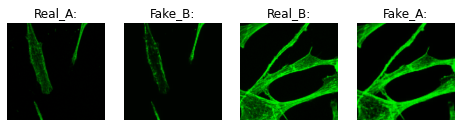

[Epoch 2/200] [Batch 625/625] [D loss: 0.247541] [G loss: 1.152035, adv: 0.549565, cycle: 0.057010, identity: 0.000000, content: 0.032369] ETA: 13:26:52.39954250528


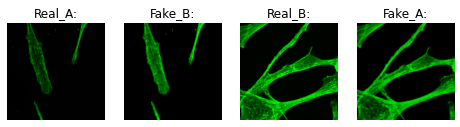

[Epoch 3/200] [Batch 625/625] [D loss: 0.245371] [G loss: 0.976803, adv: 0.546194, cycle: 0.042752, identity: 0.000000, content: 0.003092] ETA: 13:45:19.17779173525


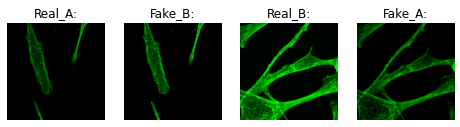

[Epoch 4/200] [Batch 625/625] [D loss: 0.241513] [G loss: 0.899884, adv: 0.577134, cycle: 0.032257, identity: 0.000000, content: 0.000183] ETA: 16:24:39.801757227320


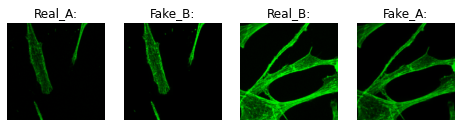

[Epoch 5/200] [Batch 625/625] [D loss: 0.243969] [G loss: 0.826402, adv: 0.562891, cycle: 0.026350, identity: 0.000000, content: 0.000007] ETA: 13:32:31.019273341215


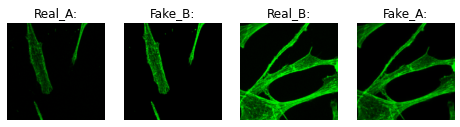

[Epoch 6/200] [Batch 625/625] [D loss: 0.247727] [G loss: 0.808569, adv: 0.548261, cycle: 0.026031, identity: 0.000000, content: 0.000000] ETA: 18:15:26.224274937687


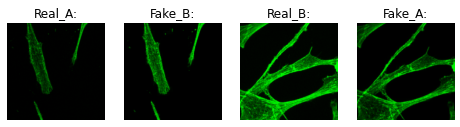

[Epoch 7/200] [Batch 625/625] [D loss: 0.247896] [G loss: 0.807187, adv: 0.540683, cycle: 0.026650, identity: 0.000000, content: 0.000000] ETA: 14:00:52.786312083393


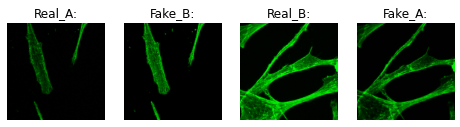

[Epoch 8/200] [Batch 625/625] [D loss: 0.245714] [G loss: 0.776985, adv: 0.541477, cycle: 0.023551, identity: 0.000000, content: 0.000000] ETA: 13:34:24.051247168335


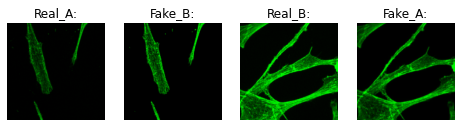

[Epoch 9/200] [Batch 625/625] [D loss: 0.251971] [G loss: 0.756407, adv: 0.532812, cycle: 0.022359, identity: 0.000000, content: 0.000000] ETA: 12:54:55.093039499217


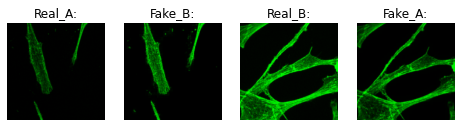

[Epoch 10/200] [Batch 625/625] [D loss: 0.247521] [G loss: 0.744391, adv: 0.524694, cycle: 0.021970, identity: 0.000000, content: 0.000000] ETA: 12:59:12.763403742029


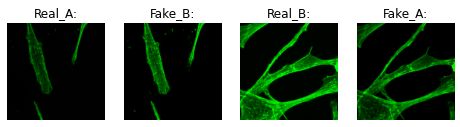

[Epoch 11/200] [Batch 625/625] [D loss: 0.248972] [G loss: 0.733755, adv: 0.521544, cycle: 0.021221, identity: 0.000000, content: 0.000000] ETA: 13:19:06.738363751267


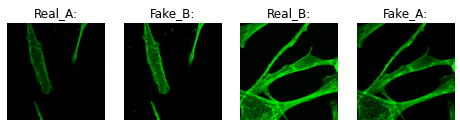

[Epoch 12/200] [Batch 625/625] [D loss: 0.247680] [G loss: 0.727989, adv: 0.522843, cycle: 0.020515, identity: 0.000000, content: 0.000000] ETA: 12:56:57.576737214189


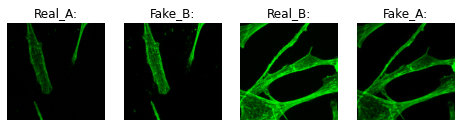

[Epoch 13/200] [Batch 625/625] [D loss: 0.248385] [G loss: 0.717078, adv: 0.516774, cycle: 0.020030, identity: 0.000000, content: 0.000000] ETA: 12:25:23.152482768161


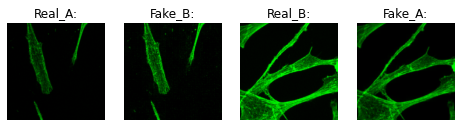

[Epoch 14/200] [Batch 625/625] [D loss: 0.248432] [G loss: 0.714143, adv: 0.518624, cycle: 0.019552, identity: 0.000000, content: 0.000000] ETA: 15:20:06.779268948573


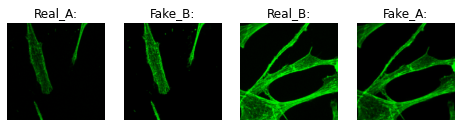

[Epoch 15/200] [Batch 625/625] [D loss: 0.248270] [G loss: 0.704042, adv: 0.516693, cycle: 0.018735, identity: 0.000000, content: 0.000000] ETA: 13:08:07.292399929204


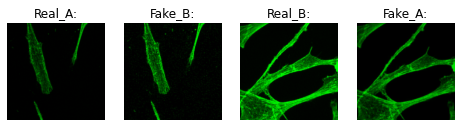

[Epoch 16/200] [Batch 625/625] [D loss: 0.248472] [G loss: 0.698189, adv: 0.516284, cycle: 0.018191, identity: 0.000000, content: 0.000000] ETA: 12:53:09.522978593838


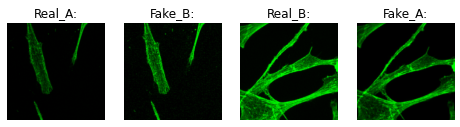

[Epoch 17/200] [Batch 625/625] [D loss: 0.248416] [G loss: 0.695044, adv: 0.515400, cycle: 0.017964, identity: 0.000000, content: 0.000000] ETA: 11:20:21.824720955752


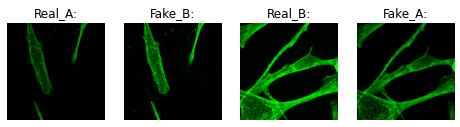

[Epoch 18/200] [Batch 625/625] [D loss: 0.248362] [G loss: 0.692910, adv: 0.516528, cycle: 0.017638, identity: 0.000000, content: 0.000000] ETA: 13:19:00.15465977537


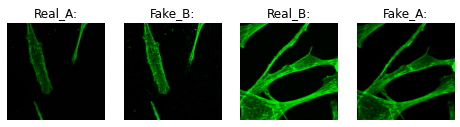

[Epoch 19/200] [Batch 625/625] [D loss: 0.248480] [G loss: 0.693623, adv: 0.517602, cycle: 0.017602, identity: 0.000000, content: 0.000000] ETA: 12:57:21.293501027201


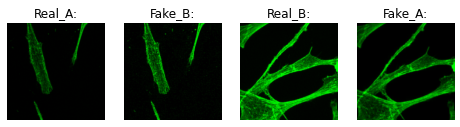

[Epoch 20/200] [Batch 625/625] [D loss: 0.250217] [G loss: 0.691920, adv: 0.517567, cycle: 0.017435, identity: 0.000000, content: 0.000000] ETA: 14:04:46.103911578798


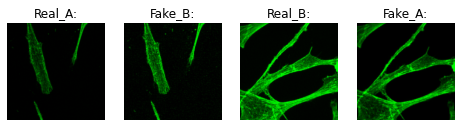

[Epoch 21/200] [Batch 625/625] [D loss: 0.248641] [G loss: 0.678875, adv: 0.513166, cycle: 0.016571, identity: 0.000000, content: 0.000000] ETA: 12:13:08.014079130817


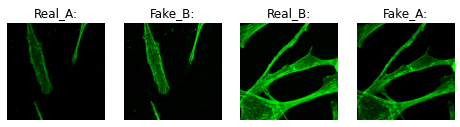

[Epoch 22/200] [Batch 625/625] [D loss: 0.248204] [G loss: 0.683048, adv: 0.516945, cycle: 0.016610, identity: 0.000000, content: 0.000000] ETA: 12:30:20.27899951407


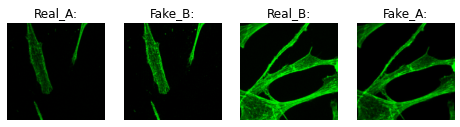

[Epoch 23/200] [Batch 625/625] [D loss: 0.249793] [G loss: 0.678342, adv: 0.514932, cycle: 0.016341, identity: 0.000000, content: 0.000000] ETA: 11:56:35.734075932318


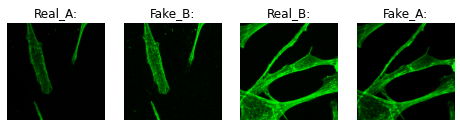

[Epoch 24/200] [Batch 625/625] [D loss: 0.248293] [G loss: 0.674651, adv: 0.517173, cycle: 0.015748, identity: 0.000000, content: 0.000000] ETA: 12:14:43.469330841702


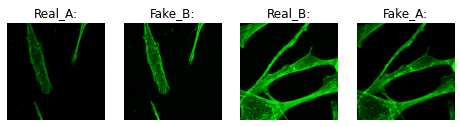

[Epoch 25/200] [Batch 625/625] [D loss: 0.248234] [G loss: 0.669262, adv: 0.516782, cycle: 0.015248, identity: 0.000000, content: 0.000000] ETA: 11:50:30.698783125742


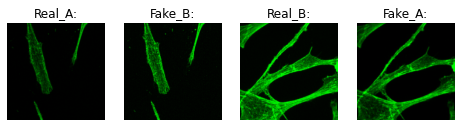

[Epoch 26/200] [Batch 625/625] [D loss: 0.248607] [G loss: 0.661662, adv: 0.515567, cycle: 0.014610, identity: 0.000000, content: 0.000000] ETA: 11:47:14.290901454427


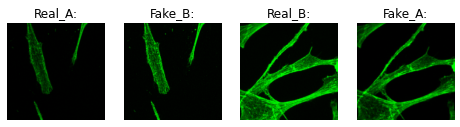

[Epoch 27/200] [Batch 625/625] [D loss: 0.248337] [G loss: 0.661588, adv: 0.515380, cycle: 0.014621, identity: 0.000000, content: 0.000000] ETA: 11:26:57.13534596575


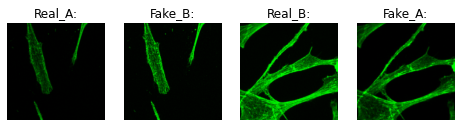

[Epoch 28/200] [Batch 625/625] [D loss: 0.249411] [G loss: 0.654648, adv: 0.514463, cycle: 0.014019, identity: 0.000000, content: 0.000000] ETA: 10:27:11.46161039986


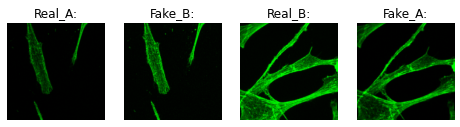

[Epoch 29/200] [Batch 625/625] [D loss: 0.249215] [G loss: 0.650487, adv: 0.514483, cycle: 0.013600, identity: 0.000000, content: 0.000000] ETA: 11:41:15.36094078023


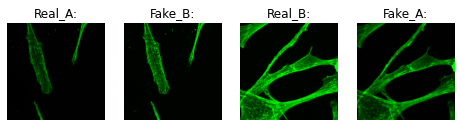

[Epoch 30/200] [Batch 625/625] [D loss: 0.248164] [G loss: 0.646419, adv: 0.516691, cycle: 0.012973, identity: 0.000000, content: 0.000000] ETA: 12:04:41.616762305274


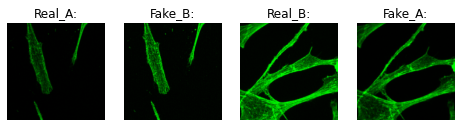

[Epoch 31/200] [Batch 625/625] [D loss: 0.248581] [G loss: 0.644651, adv: 0.519181, cycle: 0.012547, identity: 0.000000, content: 0.000000] ETA: 11:50:02.55736796840


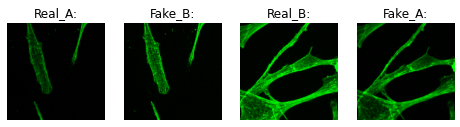

[Epoch 32/200] [Batch 625/625] [D loss: 0.248573] [G loss: 0.636944, adv: 0.516695, cycle: 0.012025, identity: 0.000000, content: 0.000000] ETA: 11:02:12.64509809698


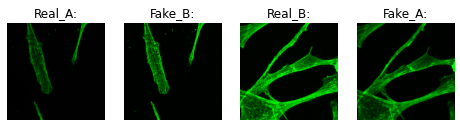

[Epoch 33/200] [Batch 625/625] [D loss: 0.248434] [G loss: 0.636857, adv: 0.517697, cycle: 0.011916, identity: 0.000000, content: 0.000000] ETA: 11:36:04.44373071862


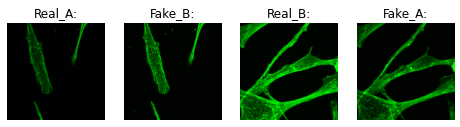

[Epoch 34/200] [Batch 625/625] [D loss: 0.248504] [G loss: 0.632707, adv: 0.517016, cycle: 0.011569, identity: 0.000000, content: 0.000000] ETA: 11:10:10.74201261802


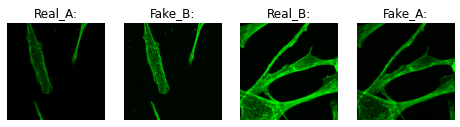

[Epoch 35/200] [Batch 625/625] [D loss: 0.248870] [G loss: 0.632455, adv: 0.519256, cycle: 0.011320, identity: 0.000000, content: 0.000000] ETA: 11:37:58.83881741970


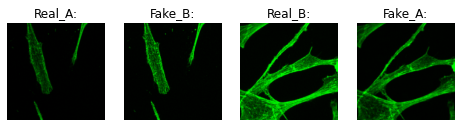

[Epoch 36/200] [Batch 625/625] [D loss: 0.248856] [G loss: 0.629488, adv: 0.516991, cycle: 0.011250, identity: 0.000000, content: 0.000000] ETA: 12:18:50.38475850954


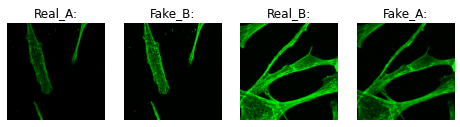

[Epoch 37/200] [Batch 625/625] [D loss: 0.248833] [G loss: 0.630125, adv: 0.516595, cycle: 0.011353, identity: 0.000000, content: 0.000000] ETA: 10:45:37.57742655026


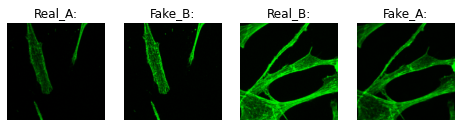

[Epoch 38/200] [Batch 625/625] [D loss: 0.248807] [G loss: 0.622880, adv: 0.515809, cycle: 0.010707, identity: 0.000000, content: 0.000000] ETA: 11:05:16.52534717927


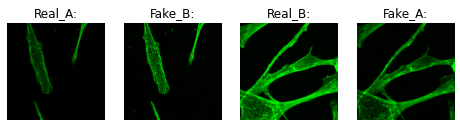

[Epoch 39/200] [Batch 625/625] [D loss: 0.248734] [G loss: 0.620842, adv: 0.516893, cycle: 0.010395, identity: 0.000000, content: 0.000000] ETA: 11:00:06.18047435908


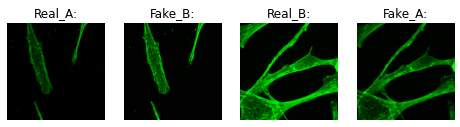

[Epoch 40/200] [Batch 625/625] [D loss: 0.248687] [G loss: 0.616615, adv: 0.516421, cycle: 0.010019, identity: 0.000000, content: 0.000000] ETA: 11:15:01.21963921088


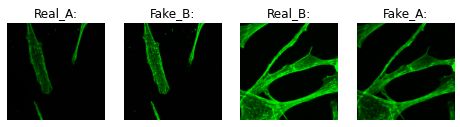

[Epoch 41/200] [Batch 625/625] [D loss: 0.248685] [G loss: 0.617089, adv: 0.517865, cycle: 0.009922, identity: 0.000000, content: 0.000000] ETA: 9:06:30.160230108893


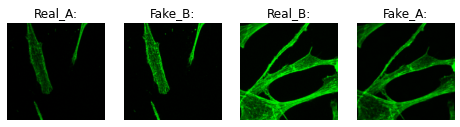

[Epoch 42/200] [Batch 625/625] [D loss: 0.249864] [G loss: 0.616189, adv: 0.520001, cycle: 0.009619, identity: 0.000000, content: 0.000000] ETA: 10:25:14.75314152502


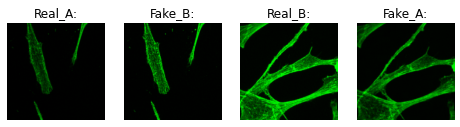

[Epoch 43/200] [Batch 625/625] [D loss: 0.248929] [G loss: 0.609879, adv: 0.516750, cycle: 0.009313, identity: 0.000000, content: 0.000000] ETA: 10:47:58.06533871881


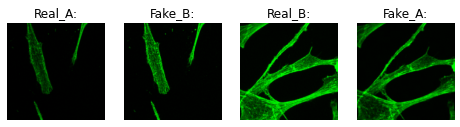

[Epoch 44/200] [Batch 625/625] [D loss: 0.248876] [G loss: 0.613681, adv: 0.518354, cycle: 0.009533, identity: 0.000000, content: 0.000000] ETA: 10:38:04.81914169792


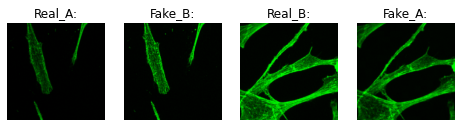

[Epoch 45/200] [Batch 625/625] [D loss: 0.248755] [G loss: 0.603223, adv: 0.516612, cycle: 0.008661, identity: 0.000000, content: 0.000000] ETA: 11:03:36.45556092323


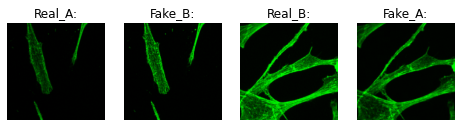

[Epoch 46/200] [Batch 625/625] [D loss: 0.248592] [G loss: 0.603926, adv: 0.515961, cycle: 0.008797, identity: 0.000000, content: 0.000000] ETA: 10:49:32.86430830643


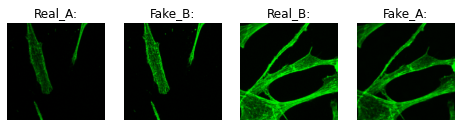

[Epoch 47/200] [Batch 625/625] [D loss: 0.248285] [G loss: 0.604213, adv: 0.519391, cycle: 0.008482, identity: 0.000000, content: 0.000000] ETA: 10:19:16.44728277570


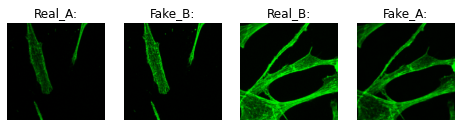

[Epoch 48/200] [Batch 625/625] [D loss: 0.249007] [G loss: 0.604193, adv: 0.517527, cycle: 0.008667, identity: 0.000000, content: 0.000000] ETA: 10:52:15.97507587831


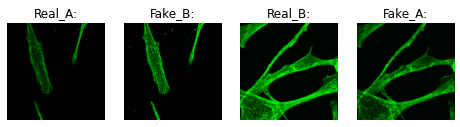

[Epoch 49/200] [Batch 625/625] [D loss: 0.248390] [G loss: 0.595816, adv: 0.516847, cycle: 0.007897, identity: 0.000000, content: 0.000000] ETA: 10:18:39.06180603762


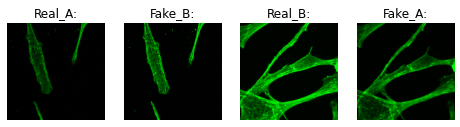

[Epoch 50/200] [Batch 625/625] [D loss: 0.248791] [G loss: 0.591702, adv: 0.517471, cycle: 0.007423, identity: 0.000000, content: 0.000000] ETA: 10:14:18.17123800779


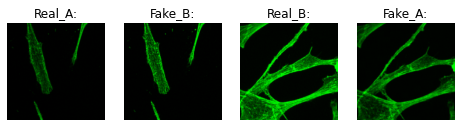

[Epoch 51/200] [Batch 625/625] [D loss: 0.248463] [G loss: 0.594075, adv: 0.517904, cycle: 0.007617, identity: 0.000000, content: 0.000000] ETA: 10:49:18.31501578873


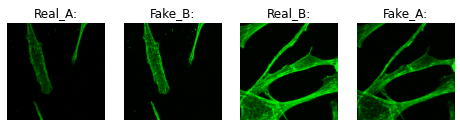

[Epoch 52/200] [Batch 625/625] [D loss: 0.248815] [G loss: 0.585191, adv: 0.514322, cycle: 0.007087, identity: 0.000000, content: 0.000000] ETA: 10:42:03.28551620962


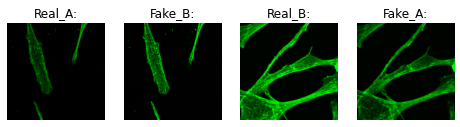

[Epoch 53/200] [Batch 625/625] [D loss: 0.248559] [G loss: 0.586902, adv: 0.516381, cycle: 0.007052, identity: 0.000000, content: 0.000000] ETA: 10:22:41.61734077743


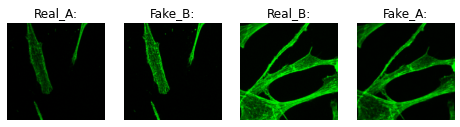

[Epoch 54/200] [Batch 625/625] [D loss: 0.248046] [G loss: 0.585945, adv: 0.517498, cycle: 0.006845, identity: 0.000000, content: 0.000000] ETA: 10:12:01.09383520187


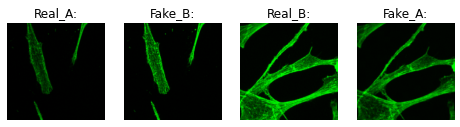

[Epoch 55/200] [Batch 625/625] [D loss: 0.248537] [G loss: 0.585250, adv: 0.517408, cycle: 0.006784, identity: 0.000000, content: 0.000000] ETA: 9:48:37.510580135479


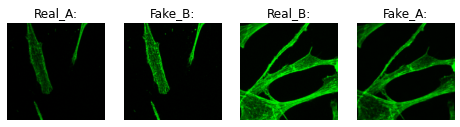

[Epoch 56/200] [Batch 625/625] [D loss: 0.248246] [G loss: 0.583932, adv: 0.517287, cycle: 0.006665, identity: 0.000000, content: 0.000000] ETA: 9:04:15.099174547779


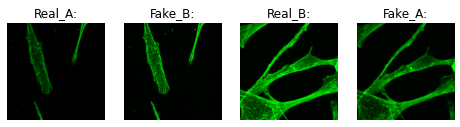

[Epoch 57/200] [Batch 625/625] [D loss: 0.249090] [G loss: 0.583781, adv: 0.517383, cycle: 0.006640, identity: 0.000000, content: 0.000000] ETA: 10:01:18.09454867853


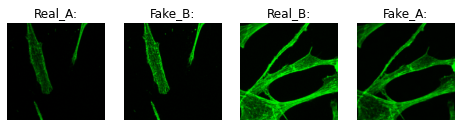

[Epoch 58/200] [Batch 625/625] [D loss: 0.248341] [G loss: 0.581895, adv: 0.517901, cycle: 0.006399, identity: 0.000000, content: 0.000000] ETA: 9:59:55.264959831582


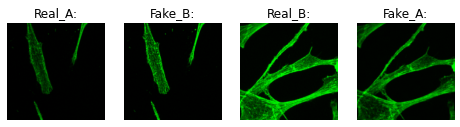

[Epoch 59/200] [Batch 625/625] [D loss: 0.248361] [G loss: 0.582712, adv: 0.516999, cycle: 0.006571, identity: 0.000000, content: 0.000000] ETA: 9:19:16.975968367310


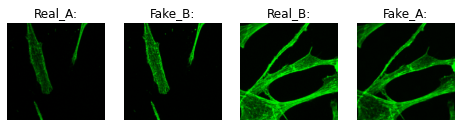

[Epoch 60/200] [Batch 625/625] [D loss: 0.247853] [G loss: 0.581140, adv: 0.519043, cycle: 0.006210, identity: 0.000000, content: 0.000000] ETA: 9:39:39.240576795175


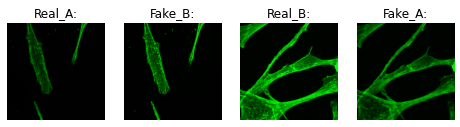

[Epoch 61/200] [Batch 625/625] [D loss: 0.248501] [G loss: 0.580724, adv: 0.516363, cycle: 0.006436, identity: 0.000000, content: 0.000000] ETA: 9:30:38.260382315049


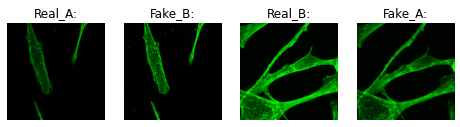

[Epoch 62/200] [Batch 625/625] [D loss: 0.248830] [G loss: 0.578264, adv: 0.517580, cycle: 0.006068, identity: 0.000000, content: 0.000000] ETA: 9:33:47.772202136008


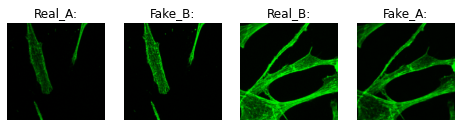

[Epoch 63/200] [Batch 625/625] [D loss: 0.248100] [G loss: 0.579558, adv: 0.518654, cycle: 0.006090, identity: 0.000000, content: 0.000000] ETA: 9:17:57.104163680400


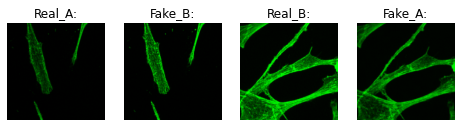

[Epoch 64/200] [Batch 625/625] [D loss: 0.248441] [G loss: 0.577172, adv: 0.517333, cycle: 0.005984, identity: 0.000000, content: 0.000000] ETA: 9:22:03.129658813025


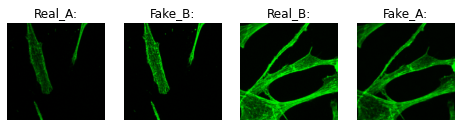

[Epoch 65/200] [Batch 625/625] [D loss: 0.248400] [G loss: 0.574941, adv: 0.517705, cycle: 0.005724, identity: 0.000000, content: 0.000000] ETA: 9:23:52.472408811531


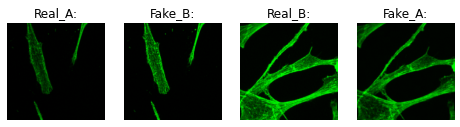

[Epoch 66/200] [Batch 625/625] [D loss: 0.247939] [G loss: 0.572012, adv: 0.517881, cycle: 0.005413, identity: 0.000000, content: 0.000000] ETA: 9:16:37.423658268369


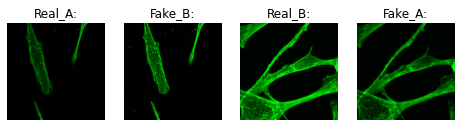

[Epoch 67/200] [Batch 625/625] [D loss: 0.248539] [G loss: 0.568731, adv: 0.516513, cycle: 0.005222, identity: 0.000000, content: 0.000000] ETA: 9:02:41.693291331754


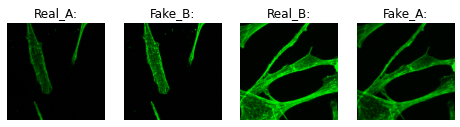

[Epoch 68/200] [Batch 625/625] [D loss: 0.248785] [G loss: 0.568402, adv: 0.515110, cycle: 0.005329, identity: 0.000000, content: 0.000000] ETA: 8:58:16.296378814031


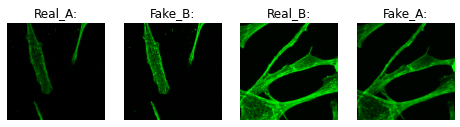

[Epoch 69/200] [Batch 625/625] [D loss: 0.248368] [G loss: 0.566896, adv: 0.516111, cycle: 0.005079, identity: 0.000000, content: 0.000000] ETA: 8:55:49.294817410089


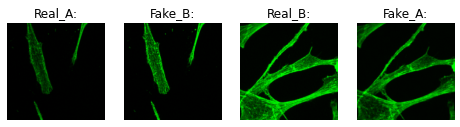

[Epoch 70/200] [Batch 625/625] [D loss: 0.248584] [G loss: 0.567888, adv: 0.517200, cycle: 0.005069, identity: 0.000000, content: 0.000000] ETA: 9:20:29.004673200296


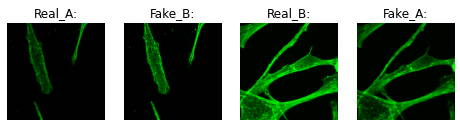

[Epoch 71/200] [Batch 625/625] [D loss: 0.248719] [G loss: 0.565894, adv: 0.516014, cycle: 0.004988, identity: 0.000000, content: 0.000000] ETA: 8:54:51.827992000301


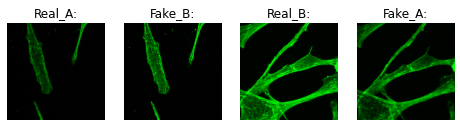

[Epoch 72/200] [Batch 625/625] [D loss: 0.248756] [G loss: 0.562893, adv: 0.515122, cycle: 0.004777, identity: 0.000000, content: 0.000000] ETA: 8:32:23.026165891980


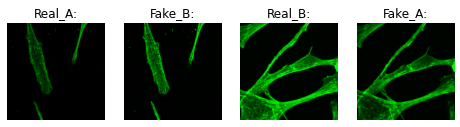

[Epoch 73/200] [Batch 625/625] [D loss: 0.248871] [G loss: 0.564234, adv: 0.515768, cycle: 0.004847, identity: 0.000000, content: 0.000000] ETA: 8:51:30.566588207499


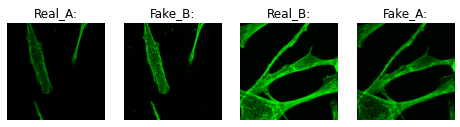

[Epoch 74/200] [Batch 625/625] [D loss: 0.248847] [G loss: 0.564313, adv: 0.516557, cycle: 0.004776, identity: 0.000000, content: 0.000000] ETA: 8:44:04.292666849029


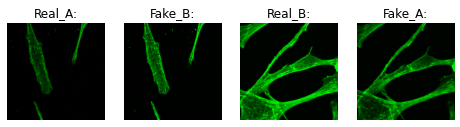

[Epoch 75/200] [Batch 625/625] [D loss: 0.248605] [G loss: 0.561477, adv: 0.515083, cycle: 0.004639, identity: 0.000000, content: 0.000000] ETA: 8:48:18.863631522105


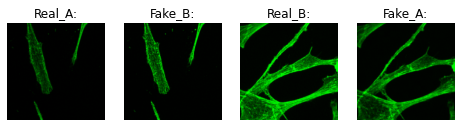

[Epoch 76/200] [Batch 625/625] [D loss: 0.248952] [G loss: 0.559613, adv: 0.513029, cycle: 0.004658, identity: 0.000000, content: 0.000000] ETA: 8:37:18.735587321713


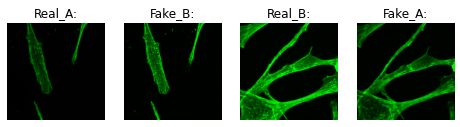

[Epoch 77/200] [Batch 625/625] [D loss: 0.248951] [G loss: 0.562008, adv: 0.514278, cycle: 0.004773, identity: 0.000000, content: 0.000000] ETA: 8:17:41.556013693480


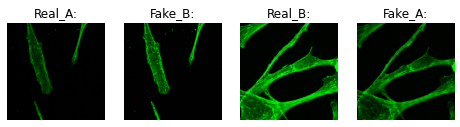

[Epoch 78/200] [Batch 625/625] [D loss: 0.248601] [G loss: 0.558833, adv: 0.513945, cycle: 0.004489, identity: 0.000000, content: 0.000000] ETA: 8:13:15.534242416446


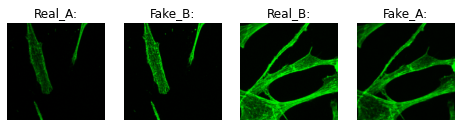

[Epoch 79/200] [Batch 625/625] [D loss: 0.248798] [G loss: 0.558091, adv: 0.512936, cycle: 0.004516, identity: 0.000000, content: 0.000000] ETA: 8:31:31.889856359134


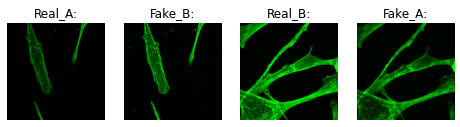

[Epoch 80/200] [Batch 625/625] [D loss: 0.248720] [G loss: 0.560732, adv: 0.516218, cycle: 0.004451, identity: 0.000000, content: 0.000000] ETA: 8:05:49.572721362324


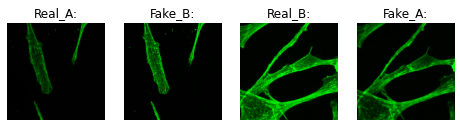

[Epoch 81/200] [Batch 625/625] [D loss: 0.248742] [G loss: 0.557088, adv: 0.513549, cycle: 0.004354, identity: 0.000000, content: 0.000000] ETA: 7:58:38.622210247563


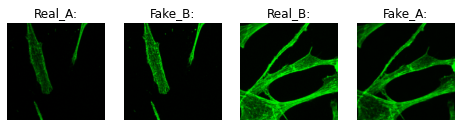

[Epoch 82/200] [Batch 625/625] [D loss: 0.248243] [G loss: 0.561395, adv: 0.516007, cycle: 0.004539, identity: 0.000000, content: 0.000000] ETA: 7:54:27.645872917968


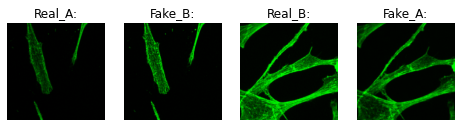

[Epoch 83/200] [Batch 625/625] [D loss: 0.248442] [G loss: 0.558652, adv: 0.514658, cycle: 0.004399, identity: 0.000000, content: 0.000000] ETA: 8:17:36.873100715797


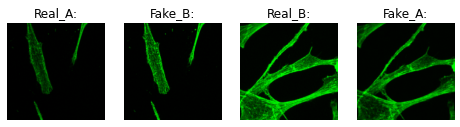

[Epoch 84/200] [Batch 625/625] [D loss: 0.248789] [G loss: 0.558917, adv: 0.514963, cycle: 0.004395, identity: 0.000000, content: 0.000000] ETA: 8:06:07.185466033528


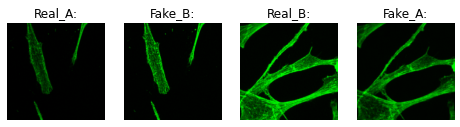

[Epoch 85/200] [Batch 625/625] [D loss: 0.248428] [G loss: 0.556356, adv: 0.513730, cycle: 0.004263, identity: 0.000000, content: 0.000000] ETA: 8:08:51.913989210327


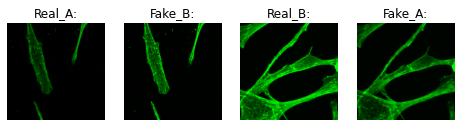

[Epoch 86/200] [Batch 625/625] [D loss: 0.248468] [G loss: 0.558343, adv: 0.515044, cycle: 0.004330, identity: 0.000000, content: 0.000000] ETA: 7:37:43.255012040377


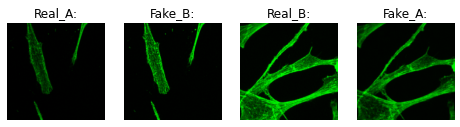

[Epoch 87/200] [Batch 625/625] [D loss: 0.248561] [G loss: 0.557748, adv: 0.515154, cycle: 0.004259, identity: 0.000000, content: 0.000000] ETA: 7:51:41.168857249067


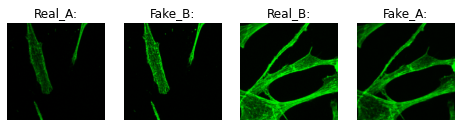

[Epoch 88/200] [Batch 625/625] [D loss: 0.248559] [G loss: 0.556701, adv: 0.513818, cycle: 0.004288, identity: 0.000000, content: 0.000000] ETA: 7:40:34.35827650781


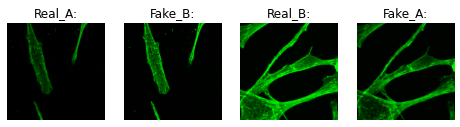

[Epoch 89/200] [Batch 625/625] [D loss: 0.248766] [G loss: 0.555709, adv: 0.514062, cycle: 0.004165, identity: 0.000000, content: 0.000000] ETA: 7:53:10.941215278048


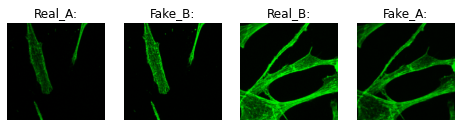

[Epoch 90/200] [Batch 625/625] [D loss: 0.248638] [G loss: 0.555268, adv: 0.513815, cycle: 0.004145, identity: 0.000000, content: 0.000000] ETA: 7:43:52.489117874308


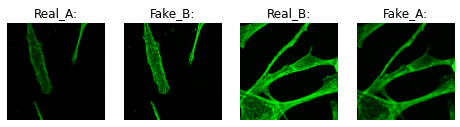

[Epoch 91/200] [Batch 625/625] [D loss: 0.248586] [G loss: 0.554766, adv: 0.513584, cycle: 0.004118, identity: 0.000000, content: 0.000000] ETA: 7:07:01.532093604512


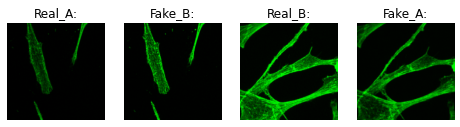

[Epoch 92/200] [Batch 625/625] [D loss: 0.248148] [G loss: 0.561008, adv: 0.517363, cycle: 0.004365, identity: 0.000000, content: 0.000000] ETA: 7:14:19.117464175281


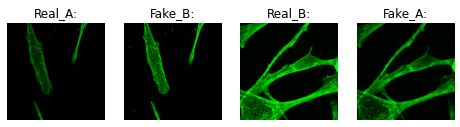

[Epoch 93/200] [Batch 625/625] [D loss: 0.248149] [G loss: 0.557742, adv: 0.515942, cycle: 0.004180, identity: 0.000000, content: 0.000000] ETA: 7:21:18.182093815950


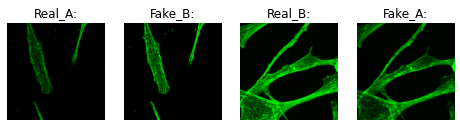

[Epoch 94/200] [Batch 625/625] [D loss: 0.248263] [G loss: 0.558667, adv: 0.517350, cycle: 0.004132, identity: 0.000000, content: 0.000000] ETA: 7:21:02.838214676056


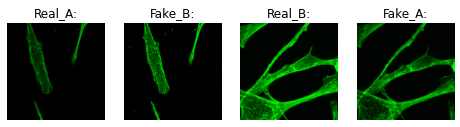

[Epoch 95/200] [Batch 625/625] [D loss: 0.249043] [G loss: 0.556268, adv: 0.516243, cycle: 0.004003, identity: 0.000000, content: 0.000000] ETA: 7:19:29.710339482414


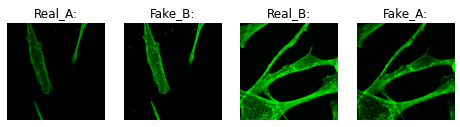

[Epoch 96/200] [Batch 625/625] [D loss: 0.248235] [G loss: 0.556126, adv: 0.516148, cycle: 0.003998, identity: 0.000000, content: 0.000000] ETA: 7:03:38.250669159904


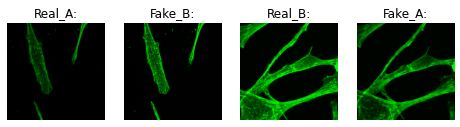

[Epoch 97/200] [Batch 625/625] [D loss: 0.248485] [G loss: 0.554679, adv: 0.515277, cycle: 0.003940, identity: 0.000000, content: 0.000000] ETA: 7:01:53.54437536273


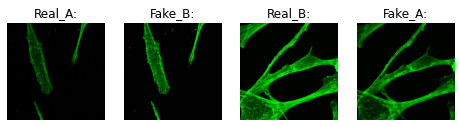

[Epoch 98/200] [Batch 625/625] [D loss: 0.248608] [G loss: 0.554186, adv: 0.515128, cycle: 0.003906, identity: 0.000000, content: 0.000000] ETA: 6:52:18.49638391206


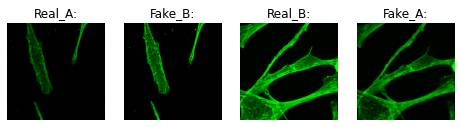

[Epoch 99/200] [Batch 625/625] [D loss: 0.248903] [G loss: 0.554380, adv: 0.514969, cycle: 0.003941, identity: 0.000000, content: 0.000000] ETA: 7:01:59.13199736181


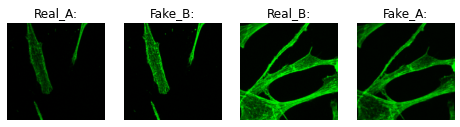

[Epoch 100/200] [Batch 625/625] [D loss: 0.248567] [G loss: 0.555945, adv: 0.515153, cycle: 0.004079, identity: 0.000000, content: 0.000000] ETA: 7:00:16.53710596411


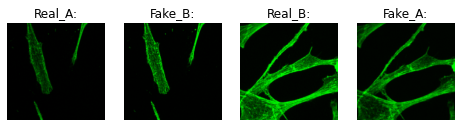

[Epoch 101/200] [Batch 625/625] [D loss: 0.247928] [G loss: 0.560113, adv: 0.517459, cycle: 0.004265, identity: 0.000000, content: 0.000000] ETA: 6:43:50.95894424864


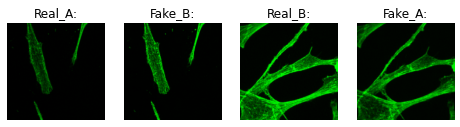

[Epoch 102/200] [Batch 625/625] [D loss: 0.248022] [G loss: 0.556582, adv: 0.517351, cycle: 0.003923, identity: 0.000000, content: 0.000000] ETA: 6:44:38.20152582950


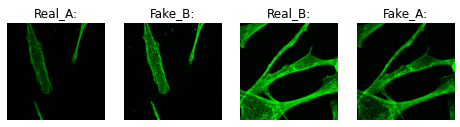

[Epoch 103/200] [Batch 625/625] [D loss: 0.248860] [G loss: 0.554947, adv: 0.516063, cycle: 0.003888, identity: 0.000000, content: 0.000000] ETA: 6:50:44.60438651123


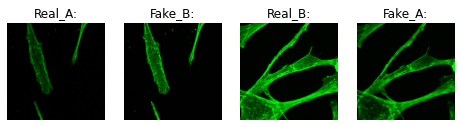

[Epoch 104/200] [Batch 625/625] [D loss: 0.248084] [G loss: 0.554109, adv: 0.515577, cycle: 0.003853, identity: 0.000000, content: 0.000000] ETA: 6:43:26.22570437186


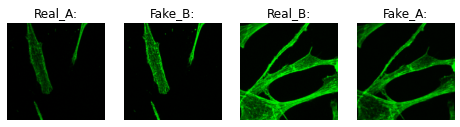

[Epoch 105/200] [Batch 625/625] [D loss: 0.248257] [G loss: 0.552981, adv: 0.516050, cycle: 0.003693, identity: 0.000000, content: 0.000000] ETA: 6:19:09.57069649468


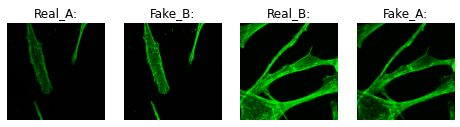

[Epoch 106/200] [Batch 625/625] [D loss: 0.248325] [G loss: 0.555116, adv: 0.517761, cycle: 0.003735, identity: 0.000000, content: 0.000000] ETA: 6:22:45.06276986350


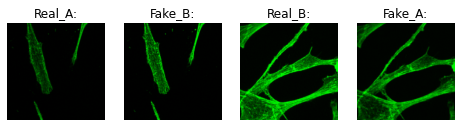

[Epoch 107/200] [Batch 625/625] [D loss: 0.247827] [G loss: 0.553731, adv: 0.516920, cycle: 0.003681, identity: 0.000000, content: 0.000000] ETA: 6:20:25.31021885942


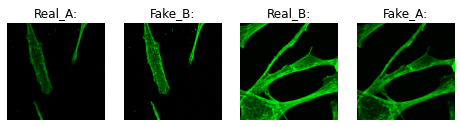

[Epoch 108/200] [Batch 625/625] [D loss: 0.248310] [G loss: 0.556537, adv: 0.516306, cycle: 0.004023, identity: 0.000000, content: 0.000000] ETA: 6:18:51.46169261415


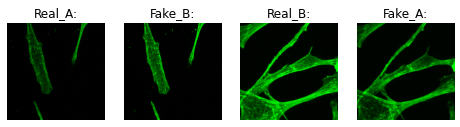

[Epoch 109/200] [Batch 625/625] [D loss: 0.248221] [G loss: 0.551182, adv: 0.516035, cycle: 0.003515, identity: 0.000000, content: 0.000000] ETA: 6:20:05.12313723692


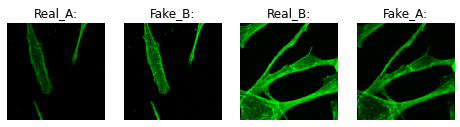

[Epoch 110/200] [Batch 625/625] [D loss: 0.247635] [G loss: 0.555725, adv: 0.519235, cycle: 0.003649, identity: 0.000000, content: 0.000000] ETA: 6:20:06.62498896096


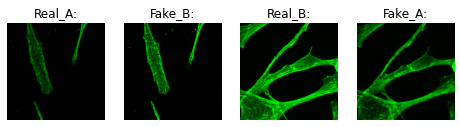

[Epoch 111/200] [Batch 625/625] [D loss: 0.248154] [G loss: 0.551382, adv: 0.515839, cycle: 0.003554, identity: 0.000000, content: 0.000000] ETA: 5:26:50.04148427190


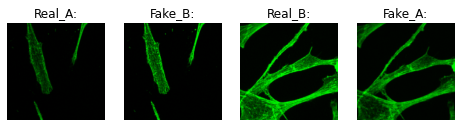

[Epoch 112/200] [Batch 625/625] [D loss: 0.248054] [G loss: 0.551839, adv: 0.516641, cycle: 0.003520, identity: 0.000000, content: 0.000000] ETA: 5:57:53.67033493685


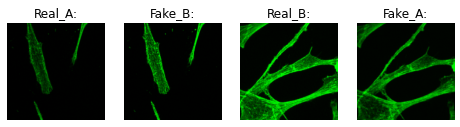

[Epoch 113/200] [Batch 625/625] [D loss: 0.248208] [G loss: 0.552981, adv: 0.516426, cycle: 0.003656, identity: 0.000000, content: 0.000000] ETA: 6:01:49.44727379921


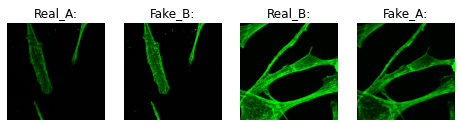

[Epoch 114/200] [Batch 625/625] [D loss: 0.247692] [G loss: 0.554099, adv: 0.518551, cycle: 0.003555, identity: 0.000000, content: 0.000000] ETA: 5:18:02.18793167172


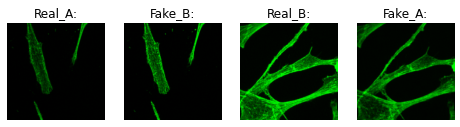

[Epoch 115/200] [Batch 625/625] [D loss: 0.247962] [G loss: 0.551953, adv: 0.518039, cycle: 0.003391, identity: 0.000000, content: 0.000000] ETA: 5:55:03.94744242856


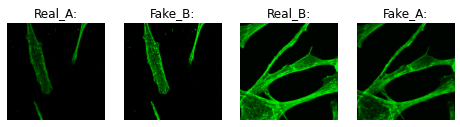

[Epoch 116/200] [Batch 625/625] [D loss: 0.248179] [G loss: 0.553143, adv: 0.519560, cycle: 0.003358, identity: 0.000000, content: 0.000000] ETA: 5:45:32.24842655383


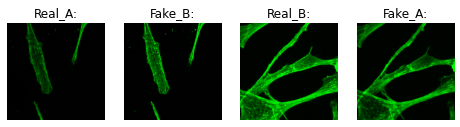

[Epoch 117/200] [Batch 625/625] [D loss: 0.248558] [G loss: 0.548508, adv: 0.513425, cycle: 0.003508, identity: 0.000000, content: 0.000000] ETA: 5:34:59.02891561461


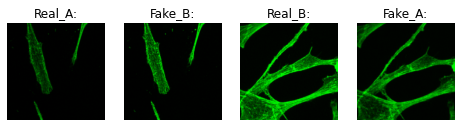

[Epoch 118/200] [Batch 625/625] [D loss: 0.248190] [G loss: 0.548779, adv: 0.516138, cycle: 0.003264, identity: 0.000000, content: 0.000000] ETA: 5:41:43.48027132791


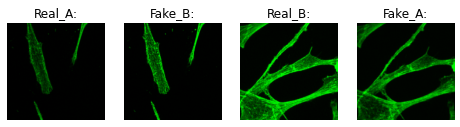

[Epoch 119/200] [Batch 625/625] [D loss: 0.247750] [G loss: 0.551269, adv: 0.517683, cycle: 0.003359, identity: 0.000000, content: 0.000000] ETA: 5:47:09.52195905001


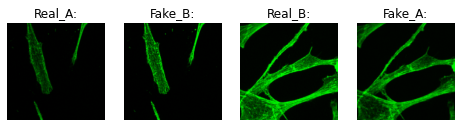

[Epoch 120/200] [Batch 625/625] [D loss: 0.247489] [G loss: 0.552206, adv: 0.518502, cycle: 0.003370, identity: 0.000000, content: 0.000000] ETA: 5:33:55.27910607606


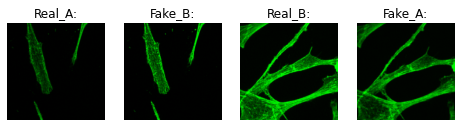

[Epoch 121/200] [Batch 625/625] [D loss: 0.247882] [G loss: 0.554038, adv: 0.518401, cycle: 0.003564, identity: 0.000000, content: 0.000000] ETA: 5:25:22.00045109902


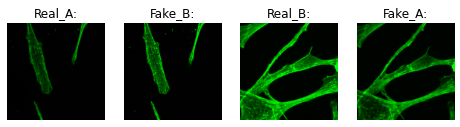

[Epoch 122/200] [Batch 625/625] [D loss: 0.247301] [G loss: 0.549204, adv: 0.517466, cycle: 0.003174, identity: 0.000000, content: 0.000000] ETA: 4:53:09.32884505138


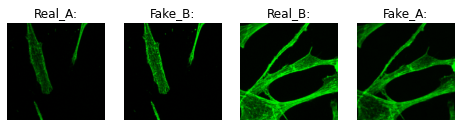

[Epoch 123/200] [Batch 625/625] [D loss: 0.247685] [G loss: 0.550421, adv: 0.518195, cycle: 0.003223, identity: 0.000000, content: 0.000000] ETA: 5:13:26.246657


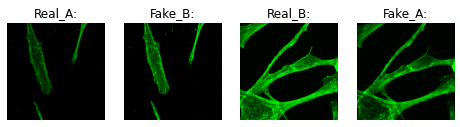

[Epoch 124/200] [Batch 625/625] [D loss: 0.247573] [G loss: 0.549117, adv: 0.517526, cycle: 0.003159, identity: 0.000000, content: 0.000000] ETA: 5:07:48.57652299348


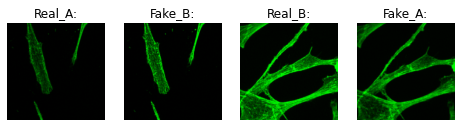

[Epoch 125/200] [Batch 625/625] [D loss: 0.248191] [G loss: 0.546890, adv: 0.515320, cycle: 0.003157, identity: 0.000000, content: 0.000000] ETA: 5:01:23.08389829567


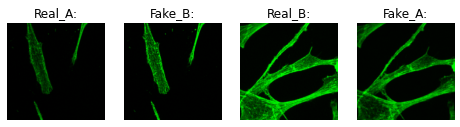

[Epoch 126/200] [Batch 625/625] [D loss: 0.247564] [G loss: 0.547995, adv: 0.516972, cycle: 0.003102, identity: 0.000000, content: 0.000000] ETA: 5:08:12.75723142269


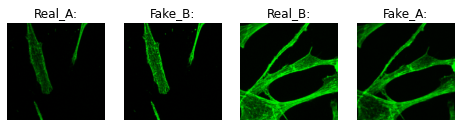

[Epoch 127/200] [Batch 625/625] [D loss: 0.247769] [G loss: 0.547759, adv: 0.517333, cycle: 0.003043, identity: 0.000000, content: 0.000000] ETA: 5:03:56.76580215302


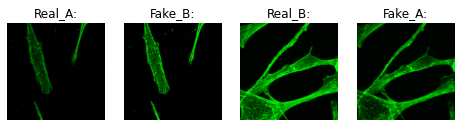

[Epoch 128/200] [Batch 625/625] [D loss: 0.249099] [G loss: 0.551513, adv: 0.520290, cycle: 0.003122, identity: 0.000000, content: 0.000000] ETA: 4:44:24.509336


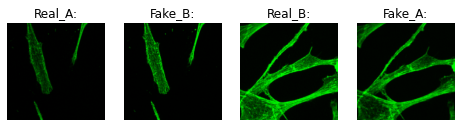

[Epoch 129/200] [Batch 625/625] [D loss: 0.248488] [G loss: 0.540817, adv: 0.512320, cycle: 0.002850, identity: 0.000000, content: 0.000000] ETA: 4:46:23.049869


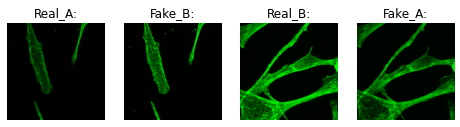

[Epoch 130/200] [Batch 625/625] [D loss: 0.247647] [G loss: 0.549077, adv: 0.517077, cycle: 0.003200, identity: 0.000000, content: 0.000000] ETA: 5:06:36.409405


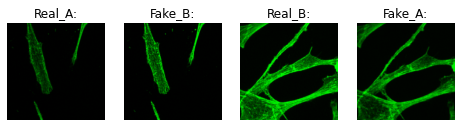

[Epoch 131/200] [Batch 625/625] [D loss: 0.247560] [G loss: 0.546047, adv: 0.517016, cycle: 0.002903, identity: 0.000000, content: 0.000000] ETA: 4:48:14.383462


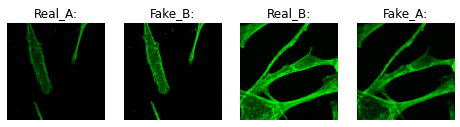

[Epoch 132/200] [Batch 625/625] [D loss: 0.247772] [G loss: 0.544978, adv: 0.516733, cycle: 0.002824, identity: 0.000000, content: 0.000000] ETA: 4:41:05.569623


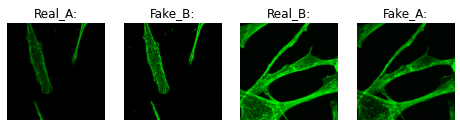

[Epoch 133/200] [Batch 625/625] [D loss: 0.247674] [G loss: 0.547671, adv: 0.518016, cycle: 0.002965, identity: 0.000000, content: 0.000000] ETA: 4:32:22.296397


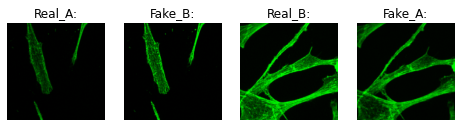

[Epoch 134/200] [Batch 625/625] [D loss: 0.248095] [G loss: 0.548709, adv: 0.518678, cycle: 0.003003, identity: 0.000000, content: 0.000000] ETA: 4:24:25.744027


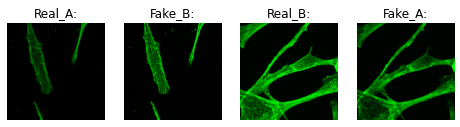

[Epoch 135/200] [Batch 625/625] [D loss: 0.247783] [G loss: 0.546118, adv: 0.516938, cycle: 0.002918, identity: 0.000000, content: 0.000000] ETA: 4:18:03.318210


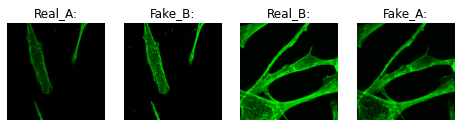

[Epoch 136/200] [Batch 625/625] [D loss: 0.247509] [G loss: 0.546501, adv: 0.518323, cycle: 0.002818, identity: 0.000000, content: 0.000000] ETA: 4:26:03.670269


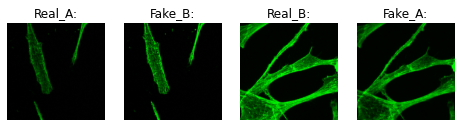

[Epoch 137/200] [Batch 625/625] [D loss: 0.246697] [G loss: 0.550337, adv: 0.521497, cycle: 0.002884, identity: 0.000000, content: 0.000000] ETA: 4:25:58.656030


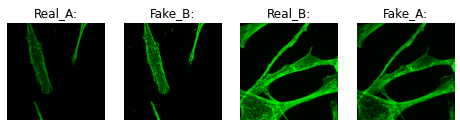

[Epoch 138/200] [Batch 625/625] [D loss: 0.246919] [G loss: 0.549955, adv: 0.520758, cycle: 0.002920, identity: 0.000000, content: 0.000000] ETA: 3:54:30.837606


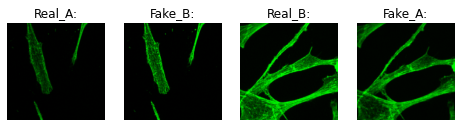

[Epoch 139/200] [Batch 625/625] [D loss: 0.246478] [G loss: 0.553401, adv: 0.524301, cycle: 0.002910, identity: 0.000000, content: 0.000000] ETA: 4:15:26.425835


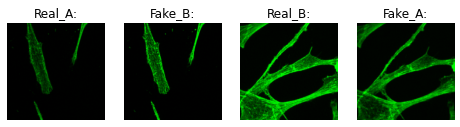

[Epoch 140/200] [Batch 625/625] [D loss: 0.247551] [G loss: 0.544328, adv: 0.517258, cycle: 0.002707, identity: 0.000000, content: 0.000000] ETA: 4:07:23.237437


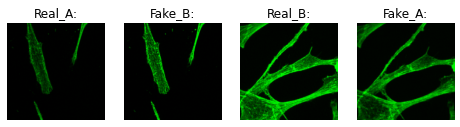

[Epoch 141/200] [Batch 625/625] [D loss: 0.246736] [G loss: 0.550053, adv: 0.522354, cycle: 0.002770, identity: 0.000000, content: 0.000000] ETA: 3:45:15.915290


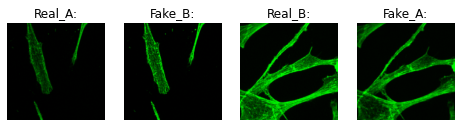

[Epoch 142/200] [Batch 625/625] [D loss: 0.246797] [G loss: 0.548505, adv: 0.520523, cycle: 0.002798, identity: 0.000000, content: 0.000000] ETA: 3:35:11.467424


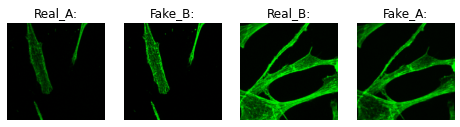

[Epoch 143/200] [Batch 625/625] [D loss: 0.247216] [G loss: 0.545024, adv: 0.518779, cycle: 0.002625, identity: 0.000000, content: 0.000000] ETA: 3:30:44.801205


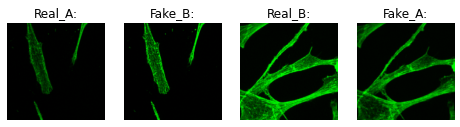

[Epoch 144/200] [Batch 625/625] [D loss: 0.247261] [G loss: 0.546414, adv: 0.519495, cycle: 0.002692, identity: 0.000000, content: 0.000000] ETA: 4:18:42.335510


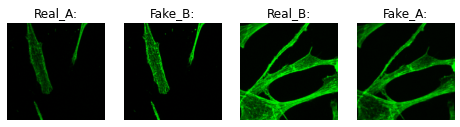

[Epoch 145/200] [Batch 625/625] [D loss: 0.246533] [G loss: 0.548726, adv: 0.521635, cycle: 0.002709, identity: 0.000000, content: 0.000000] ETA: 3:17:03.718096


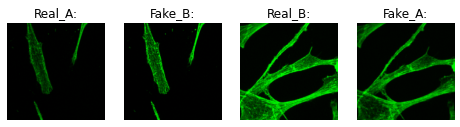

[Epoch 146/200] [Batch 625/625] [D loss: 0.247437] [G loss: 0.544688, adv: 0.517855, cycle: 0.002683, identity: 0.000000, content: 0.000000] ETA: 3:43:55.599934


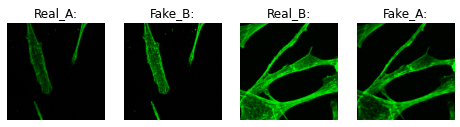

[Epoch 147/200] [Batch 625/625] [D loss: 0.246000] [G loss: 0.552139, adv: 0.523600, cycle: 0.002854, identity: 0.000000, content: 0.000000] ETA: 3:40:08.335532


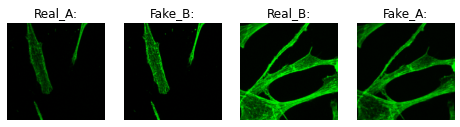

[Epoch 148/200] [Batch 625/625] [D loss: 0.246514] [G loss: 0.548780, adv: 0.522267, cycle: 0.002651, identity: 0.000000, content: 0.000000] ETA: 3:41:02.000838


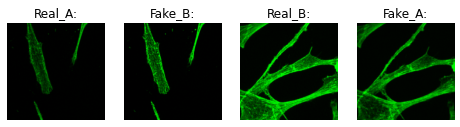

[Epoch 149/200] [Batch 625/625] [D loss: 0.246319] [G loss: 0.549088, adv: 0.522101, cycle: 0.002699, identity: 0.000000, content: 0.000000] ETA: 3:32:23.150664


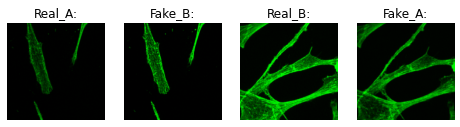

[Epoch 150/200] [Batch 625/625] [D loss: 0.246615] [G loss: 0.548581, adv: 0.522244, cycle: 0.002634, identity: 0.000000, content: 0.000000] ETA: 3:23:18.450561


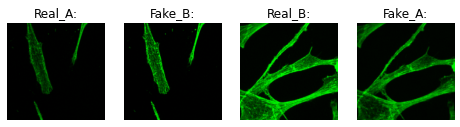

[Epoch 151/200] [Batch 625/625] [D loss: 0.246016] [G loss: 0.550134, adv: 0.523790, cycle: 0.002634, identity: 0.000000, content: 0.000000] ETA: 3:07:51.754707


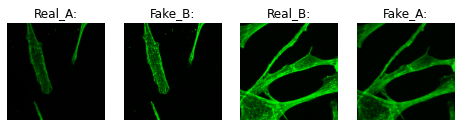

[Epoch 152/200] [Batch 625/625] [D loss: 0.246324] [G loss: 0.547922, adv: 0.522511, cycle: 0.002541, identity: 0.000000, content: 0.000000] ETA: 3:28:11.270096


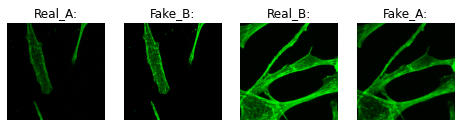

[Epoch 153/200] [Batch 625/625] [D loss: 0.245790] [G loss: 0.549585, adv: 0.523755, cycle: 0.002583, identity: 0.000000, content: 0.000000] ETA: 3:12:01.734794


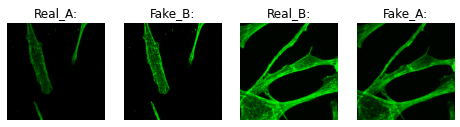

[Epoch 154/200] [Batch 625/625] [D loss: 0.245662] [G loss: 0.553587, adv: 0.526004, cycle: 0.002758, identity: 0.000000, content: 0.000000] ETA: 3:06:43.817761


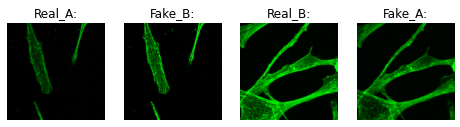

[Epoch 155/200] [Batch 625/625] [D loss: 0.246289] [G loss: 0.549785, adv: 0.524417, cycle: 0.002537, identity: 0.000000, content: 0.000000] ETA: 3:06:03.849270


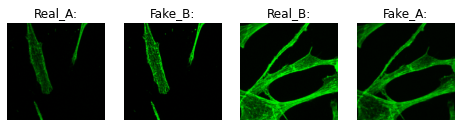

[Epoch 156/200] [Batch 625/625] [D loss: 0.245744] [G loss: 0.551092, adv: 0.525379, cycle: 0.002571, identity: 0.000000, content: 0.000000] ETA: 2:45:39.830148


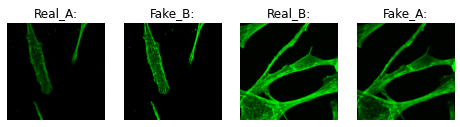

[Epoch 157/200] [Batch 625/625] [D loss: 0.245488] [G loss: 0.550617, adv: 0.526095, cycle: 0.002452, identity: 0.000000, content: 0.000000] ETA: 2:56:24.594887


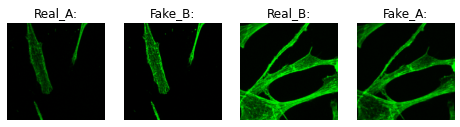

[Epoch 158/200] [Batch 625/625] [D loss: 0.246366] [G loss: 0.550839, adv: 0.525670, cycle: 0.002517, identity: 0.000000, content: 0.000000] ETA: 2:48:57.183324


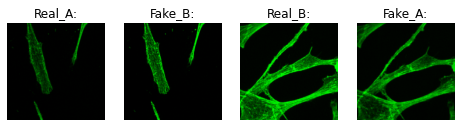

[Epoch 159/200] [Batch 625/625] [D loss: 0.245496] [G loss: 0.550790, adv: 0.525953, cycle: 0.002484, identity: 0.000000, content: 0.000000] ETA: 3:02:03.214564


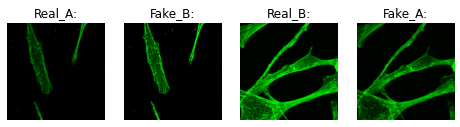

[Epoch 160/200] [Batch 625/625] [D loss: 0.245932] [G loss: 0.548967, adv: 0.523699, cycle: 0.002527, identity: 0.000000, content: 0.000000] ETA: 2:47:01.941977


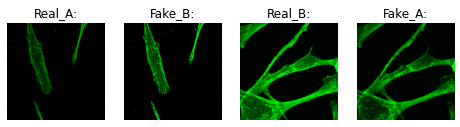

[Epoch 161/200] [Batch 625/625] [D loss: 0.245337] [G loss: 0.553229, adv: 0.528036, cycle: 0.002519, identity: 0.000000, content: 0.000000] ETA: 2:42:03.132445


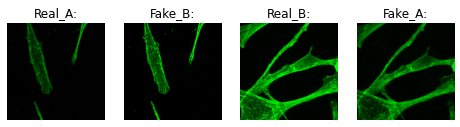

[Epoch 162/200] [Batch 625/625] [D loss: 0.245164] [G loss: 0.552463, adv: 0.527162, cycle: 0.002530, identity: 0.000000, content: 0.000000] ETA: 2:35:41.515570


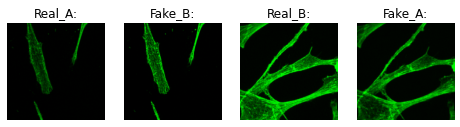

[Epoch 163/200] [Batch 625/625] [D loss: 0.245565] [G loss: 0.549478, adv: 0.525952, cycle: 0.002353, identity: 0.000000, content: 0.000000] ETA: 2:30:11.383598


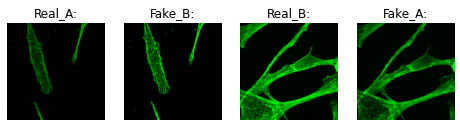

[Epoch 164/200] [Batch 625/625] [D loss: 0.245080] [G loss: 0.552247, adv: 0.527915, cycle: 0.002433, identity: 0.000000, content: 0.000000] ETA: 2:27:30.949287


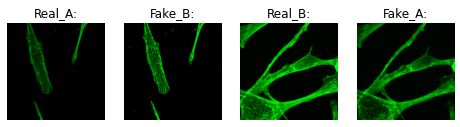

[Epoch 165/200] [Batch 625/625] [D loss: 0.245433] [G loss: 0.550522, adv: 0.526252, cycle: 0.002427, identity: 0.000000, content: 0.000000] ETA: 2:25:47.055865


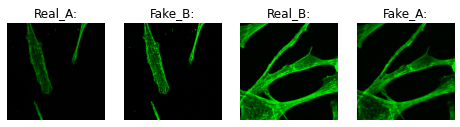

[Epoch 166/200] [Batch 625/625] [D loss: 0.245018] [G loss: 0.550698, adv: 0.526419, cycle: 0.002428, identity: 0.000000, content: 0.000000] ETA: 2:12:59.219723


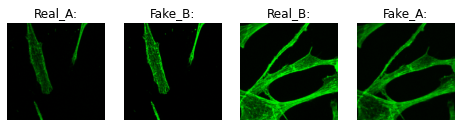

[Epoch 167/200] [Batch 625/625] [D loss: 0.244955] [G loss: 0.551548, adv: 0.527589, cycle: 0.002396, identity: 0.000000, content: 0.000000] ETA: 2:11:38.763754


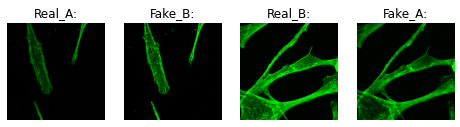

[Epoch 168/200] [Batch 625/625] [D loss: 0.244906] [G loss: 0.550397, adv: 0.526574, cycle: 0.002382, identity: 0.000000, content: 0.000000] ETA: 2:11:47.408138


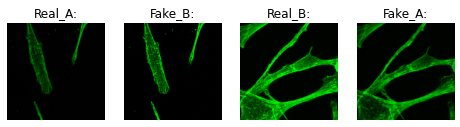

[Epoch 169/200] [Batch 625/625] [D loss: 0.245085] [G loss: 0.551409, adv: 0.526745, cycle: 0.002466, identity: 0.000000, content: 0.000000] ETA: 2:04:22.741565


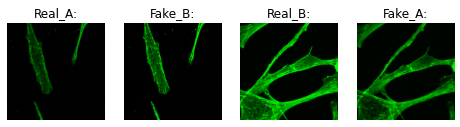

[Epoch 170/200] [Batch 625/625] [D loss: 0.243950] [G loss: 0.554473, adv: 0.530756, cycle: 0.002372, identity: 0.000000, content: 0.000000] ETA: 2:05:15.590867


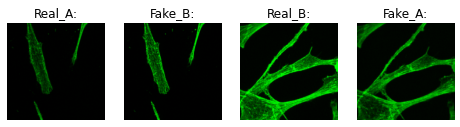

[Epoch 171/200] [Batch 625/625] [D loss: 0.244428] [G loss: 0.552188, adv: 0.529030, cycle: 0.002316, identity: 0.000000, content: 0.000000] ETA: 1:56:15.199385


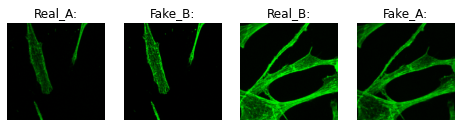

[Epoch 172/200] [Batch 625/625] [D loss: 0.245433] [G loss: 0.552372, adv: 0.528940, cycle: 0.002343, identity: 0.000000, content: 0.000000] ETA: 1:38:43.074836


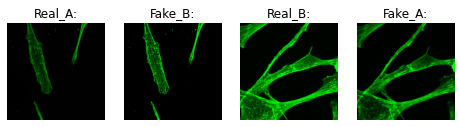

[Epoch 173/200] [Batch 625/625] [D loss: 0.243862] [G loss: 0.554587, adv: 0.530057, cycle: 0.002453, identity: 0.000000, content: 0.000000] ETA: 1:34:32.098444


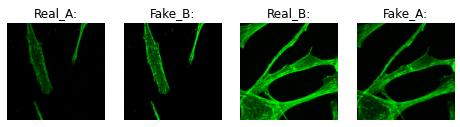

[Epoch 174/200] [Batch 625/625] [D loss: 0.244572] [G loss: 0.551490, adv: 0.527990, cycle: 0.002350, identity: 0.000000, content: 0.000000] ETA: 1:50:36.738818


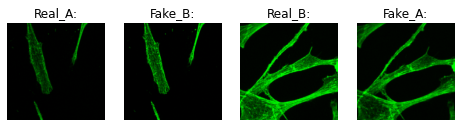

[Epoch 175/200] [Batch 625/625] [D loss: 0.243925] [G loss: 0.554188, adv: 0.530476, cycle: 0.002371, identity: 0.000000, content: 0.000000] ETA: 1:43:26.011822


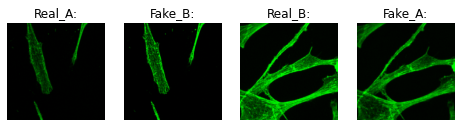

[Epoch 176/200] [Batch 625/625] [D loss: 0.243645] [G loss: 0.555430, adv: 0.532119, cycle: 0.002331, identity: 0.000000, content: 0.000000] ETA: 1:37:21.535315


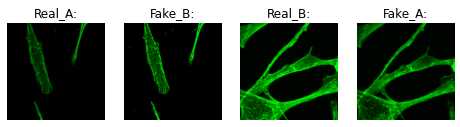

[Epoch 177/200] [Batch 625/625] [D loss: 0.243633] [G loss: 0.553379, adv: 0.530667, cycle: 0.002271, identity: 0.000000, content: 0.000000] ETA: 1:29:19.147403


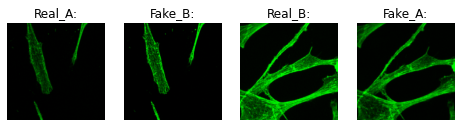

[Epoch 178/200] [Batch 625/625] [D loss: 0.243416] [G loss: 0.552981, adv: 0.530574, cycle: 0.002241, identity: 0.000000, content: 0.000000] ETA: 1:28:09.278810


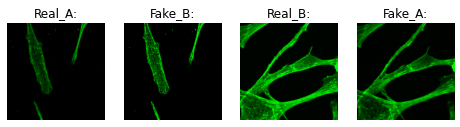

[Epoch 179/200] [Batch 625/625] [D loss: 0.243358] [G loss: 0.554696, adv: 0.531136, cycle: 0.002356, identity: 0.000000, content: 0.000000] ETA: 1:24:23.900120


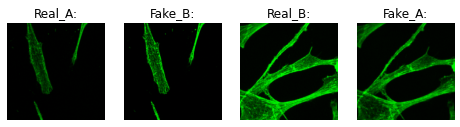

[Epoch 180/200] [Batch 625/625] [D loss: 0.243486] [G loss: 0.551612, adv: 0.529591, cycle: 0.002202, identity: 0.000000, content: 0.000000] ETA: 1:13:29.057419


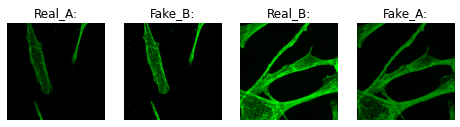

[Epoch 181/200] [Batch 625/625] [D loss: 0.242947] [G loss: 0.553696, adv: 0.531186, cycle: 0.002251, identity: 0.000000, content: 0.000000] ETA: 1:15:30.288902


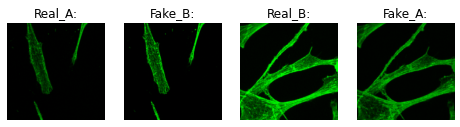

[Epoch 182/200] [Batch 625/625] [D loss: 0.243128] [G loss: 0.553739, adv: 0.531044, cycle: 0.002269, identity: 0.000000, content: 0.000000] ETA: 1:10:28.998548


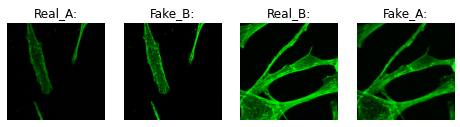

[Epoch 183/200] [Batch 625/625] [D loss: 0.243198] [G loss: 0.552302, adv: 0.529757, cycle: 0.002255, identity: 0.000000, content: 0.000000] ETA: 1:06:15.958221


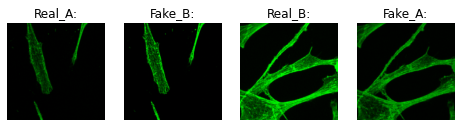

[Epoch 184/200] [Batch 625/625] [D loss: 0.242878] [G loss: 0.555811, adv: 0.533027, cycle: 0.002278, identity: 0.000000, content: 0.000000] ETA: 1:01:42.598831


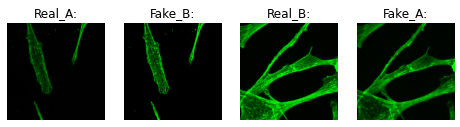

[Epoch 185/200] [Batch 625/625] [D loss: 0.242144] [G loss: 0.558829, adv: 0.535030, cycle: 0.002380, identity: 0.000000, content: 0.000000] ETA: 0:58:30.473979


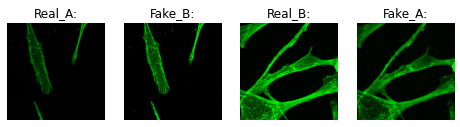

[Epoch 186/200] [Batch 625/625] [D loss: 0.242153] [G loss: 0.560496, adv: 0.536504, cycle: 0.002399, identity: 0.000000, content: 0.000000] ETA: 0:53:58.669882


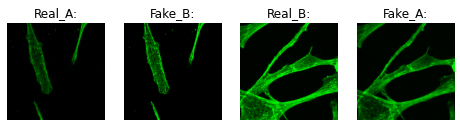

[Epoch 187/200] [Batch 625/625] [D loss: 0.242790] [G loss: 0.556001, adv: 0.533521, cycle: 0.002248, identity: 0.000000, content: 0.000000] ETA: 0:50:13.150060


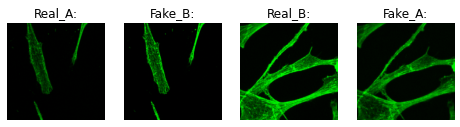

[Epoch 188/200] [Batch 625/625] [D loss: 0.242185] [G loss: 0.558099, adv: 0.534660, cycle: 0.002344, identity: 0.000000, content: 0.000000] ETA: 0:45:13.418195


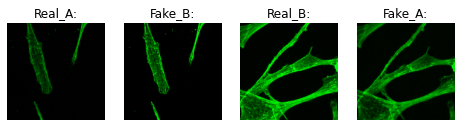

[Epoch 189/200] [Batch 625/625] [D loss: 0.242465] [G loss: 0.557059, adv: 0.534286, cycle: 0.002277, identity: 0.000000, content: 0.000000] ETA: 0:40:47.785120


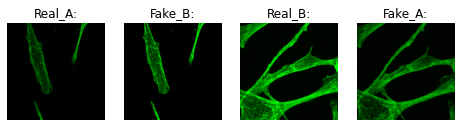

[Epoch 190/200] [Batch 625/625] [D loss: 0.242127] [G loss: 0.556988, adv: 0.534965, cycle: 0.002202, identity: 0.000000, content: 0.000000] ETA: 0:37:46.216311


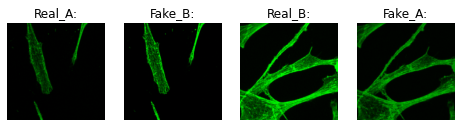

[Epoch 191/200] [Batch 625/625] [D loss: 0.242190] [G loss: 0.555070, adv: 0.532095, cycle: 0.002297, identity: 0.000000, content: 0.000000] ETA: 0:34:03.023937


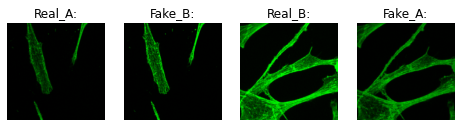

[Epoch 192/200] [Batch 625/625] [D loss: 0.241488] [G loss: 0.553316, adv: 0.529902, cycle: 0.002341, identity: 0.000000, content: 0.000000] ETA: 0:30:17.786350


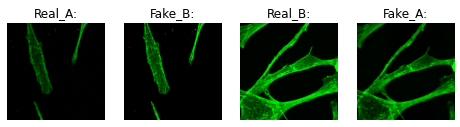

[Epoch 193/200] [Batch 625/625] [D loss: 0.241790] [G loss: 0.553106, adv: 0.530568, cycle: 0.002254, identity: 0.000000, content: 0.000000] ETA: 0:24:27.806405


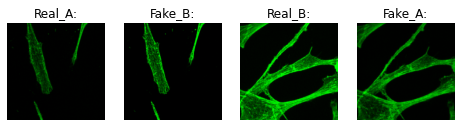

[Epoch 194/200] [Batch 625/625] [D loss: 0.242392] [G loss: 0.552084, adv: 0.529943, cycle: 0.002214, identity: 0.000000, content: 0.000000] ETA: 0:20:31.061345


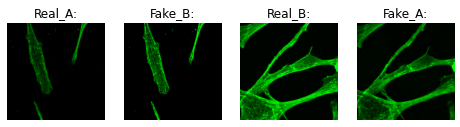

[Epoch 195/200] [Batch 625/625] [D loss: 0.241988] [G loss: 0.552985, adv: 0.530352, cycle: 0.002263, identity: 0.000000, content: 0.000000] ETA: 0:17:18.640583


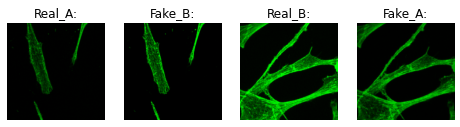

[Epoch 196/200] [Batch 625/625] [D loss: 0.241251] [G loss: 0.552465, adv: 0.529643, cycle: 0.002282, identity: 0.000000, content: 0.000000] ETA: 0:12:44.826083


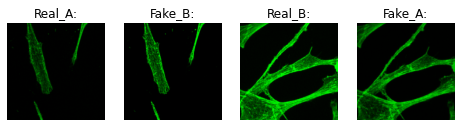

[Epoch 197/200] [Batch 625/625] [D loss: 0.241050] [G loss: 0.551208, adv: 0.528329, cycle: 0.002288, identity: 0.000000, content: 0.000000] ETA: 0:08:58.653368


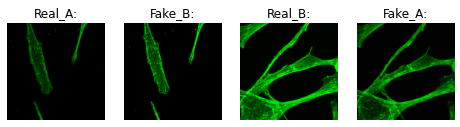

[Epoch 198/200] [Batch 625/625] [D loss: 0.240614] [G loss: 0.552139, adv: 0.528828, cycle: 0.002331, identity: 0.000000, content: 0.000000] ETA: 0:04:17.171086


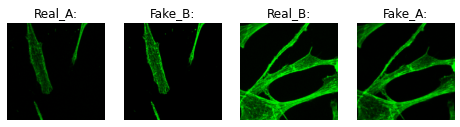

[Epoch 199/200] [Batch 625/625] [D loss: 0.241065] [G loss: 0.550334, adv: 0.527673, cycle: 0.002266, identity: 0.000000, content: 0.000000] ETA: 0:00:00.398503


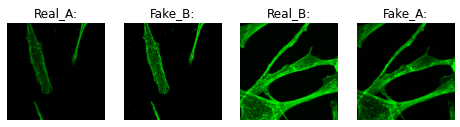

[Epoch 200/200] [Batch 625/625] [D loss: 0.242713] [G loss: 0.546066, adv: 0.523639, cycle: 0.002243, identity: 0.000000, content: 0.000000] ETA: -1 day, 23:55:05.844303


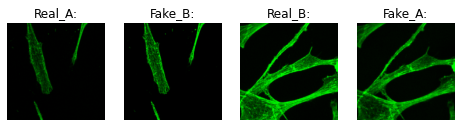

save my model finished !!


In [59]:
train()

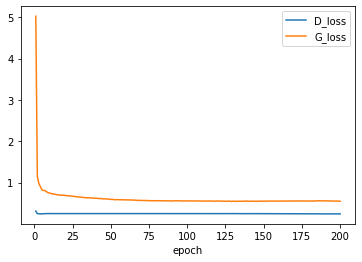

In [60]:
plt.plot(range(1, len(D_loss)+1), D_loss, label='D_loss')
plt.plot(range(1, len(D_loss)+1), G_loss, label='G_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [61]:
print(D_loss)

[0.309388236784935, 0.24754066033363342, 0.24537147755622865, 0.24151331062316894, 0.2439690381526947, 0.2477266625881195, 0.24789622418880464, 0.24571436929702759, 0.25197092616558076, 0.24752095081806183, 0.24897218928337098, 0.2476801864862442, 0.24838514049053192, 0.24843164858818054, 0.24826952884197234, 0.24847216756343843, 0.248415581202507, 0.24836187422275544, 0.24847958309650423, 0.2502168681383133, 0.24864050147533417, 0.2482037757873535, 0.2497931357383728, 0.2482929584980011, 0.24823350670337677, 0.24860714354515076, 0.2483369723558426, 0.2494106237888336, 0.24921486222743988, 0.24816388957500457, 0.2485811849832535, 0.24857294626235962, 0.2484343281507492, 0.24850359165668487, 0.2488700490951538, 0.24885640428066252, 0.24883347814083098, 0.248806747174263, 0.24873449974060058, 0.24868656027317046, 0.2486853910446167, 0.24986364483833312, 0.2489292426586151, 0.2488755845308304, 0.24875513858795165, 0.24859240996837617, 0.24828482186794282, 0.24900727550983429, 0.2483900213

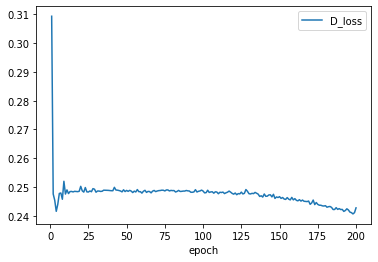

In [62]:
plt.plot(range(1,len(D_loss)+1),D_loss,label = 'D_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

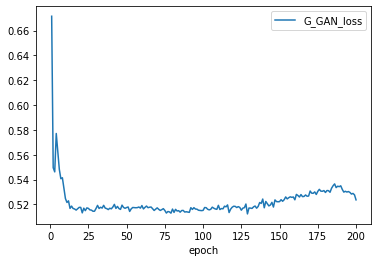

In [63]:
plt.plot(range(1,len(G_GAN_loss)+1),G_GAN_loss,label = 'G_GAN_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

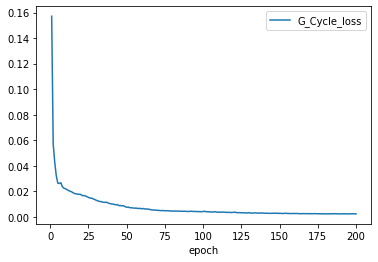

In [64]:
plt.plot(range(1,len(G_Cycle_loss)+1),G_Cycle_loss,label = 'G_Cycle_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

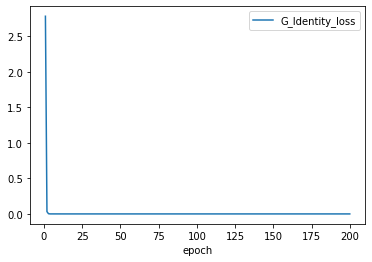

In [65]:
plt.plot(range(1,len(G_Content_loss)+1),G_Content_loss,label = 'G_Identity_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [66]:
print(len(test_dataloader))

126


In [67]:
def test():
    G_AB.load_state_dict(torch.load('./save/G_AB0198.pth'))
    
    G_AB.eval()
    os.makedirs('./outputs/B',exist_ok=True)
    for i,(A,B) in enumerate(test_dataloader):
        real_A = Variable(A).cuda()
        real_B = Variable(B).cuda()
        fake_B = 0.5 * (G_AB(real_A).data + 1.0)
        real_A = 0.5*(real_A.data+1.0)
        real_B = 0.5*(real_B.data+1.0)
        save_image(real_A,'outputs/input/%04d.tif'%(i+1))
        save_image(fake_B,'outputs/output/%04d.tif'%(i+1))
        save_image(real_B,'outputs/ground_truth/%04d.tif'%(i+1))

In [68]:
os.makedirs('./outputs/input/',exist_ok = True)
os.makedirs('./outputs/output/',exist_ok = True)
os.makedirs('./outputs/ground_truth/',exist_ok = True)

In [69]:
test()